<a href="https://colab.research.google.com/github/genaiconference/AgenticAI_GenAIHack/blob/main/05_movie_storyboarding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

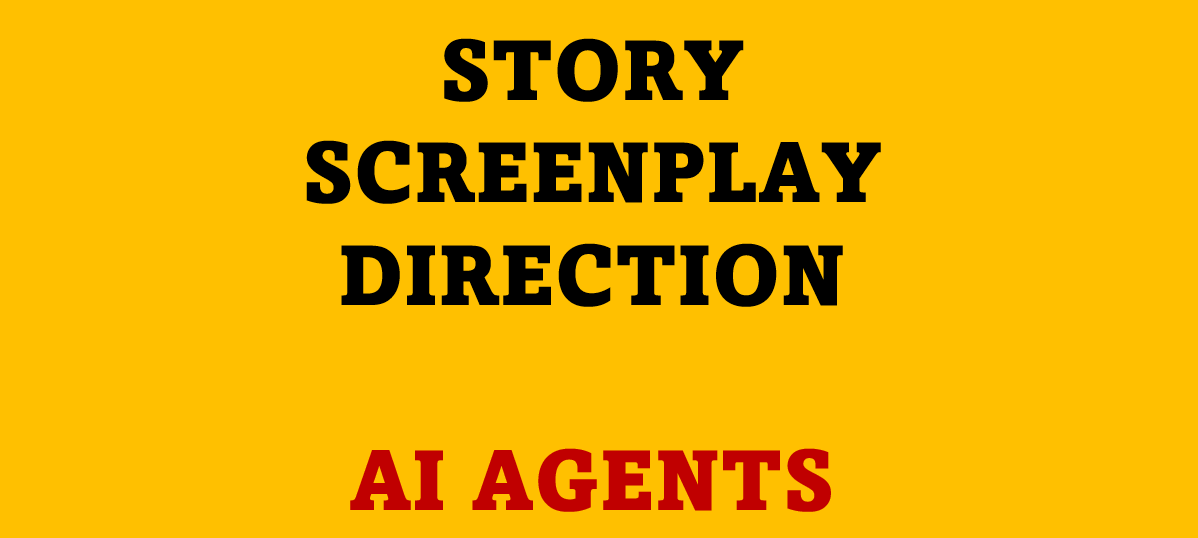

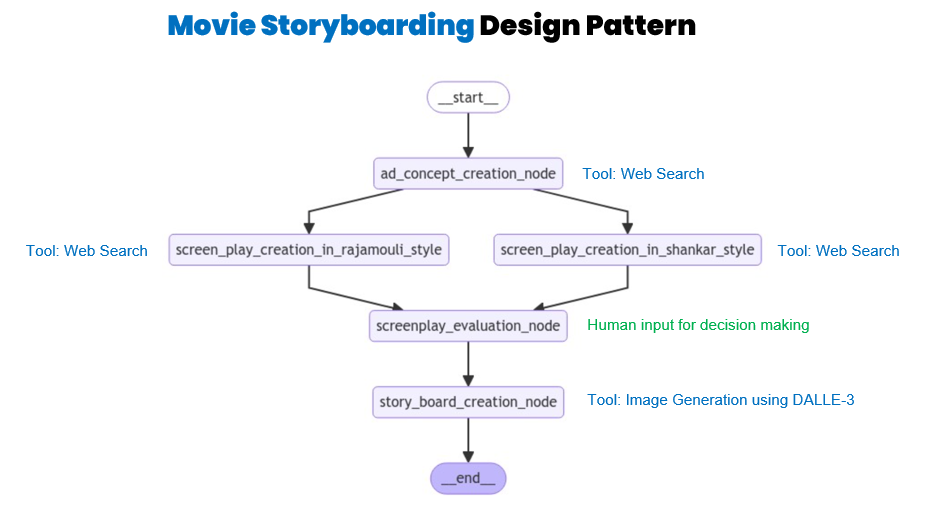

In [1]:
# @title
# Wrap Text on Colab
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [2]:
# @title
# Set Custom height on colab notebook
from google.colab.output import eval_js
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})')

In [3]:
!pip install -q langchain==0.2.9 langchain-openai==0.1.7 langchain-community==0.2.9 langgraph==0.0.55 tavily-python==0.3.5 python_dotenv==1.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 987.7/987.7 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.9/379.9 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.2/140.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.7/336.7 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58

Define LLM

Load environment variables

In [6]:
import os
from dotenv import load_dotenv
load_dotenv(dotenv_path=".env")

True

Define LLM

In [7]:
# @title
GPT4o_DEPLOYMENT_NAME = os.getenv('GPT4o_DEPLOYMENT_NAME')
DALL_E_3_DEPLOYMENT_NAME = os.getenv('DALL_E_3_DEPLOYMENT_NAME')

API_TYPE = os.getenv('API_TYPE')
API_VERSION = os.getenv('API_VERSION')

EAST_US_2_API_KEY = os.getenv('east_us2_API_KEY')
EAST_US_2_API_BASE = os.getenv('east_us2_API_BASE')

AUS_API_KEY = os.getenv('australia_API_KEY')
AUS_API_BASE = os.getenv('australia_API_BASE')

In [8]:
from openai import AzureOpenAI
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
        azure_endpoint=EAST_US_2_API_BASE,
        api_version=API_VERSION,
        azure_deployment=GPT4o_DEPLOYMENT_NAME,
        openai_api_key=EAST_US_2_API_KEY,
        temperature=0)

image_llm = AzureOpenAI(
        azure_endpoint=AUS_API_BASE,
        api_version=API_VERSION,
        api_key=AUS_API_KEY)

Define the utility functions for the Nodes

* **Agent**:
  * Concept Creator
  * Screenplay Writer
  * Storyboard Creator
* **Tools**:
  * Image generation using DALLE-3
  * Tavily API for web search

In [9]:
import json
from langchain.tools import tool
from IPython.display import display, Image, Markdown
from langchain_openai import ChatOpenAI
from langchain.agents import Tool, AgentExecutor, create_openai_tools_agent
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.tools.retriever import create_retriever_tool
from langchain_community.retrievers import TavilySearchAPIRetriever
from langchain_core.messages import HumanMessage


# Create a tool to search the internet using TavilySearchAPI
def get_tavily_search_retriever():
    retriever = TavilySearchAPIRetriever(k=7)
    retriever_description = "Use this tool when you need to answer questions related to current events and latest happenings or anything related to the user ask"
    retrieve_tool = create_retriever_tool(retriever=retriever, name="internet_search", description=retriever_description)
    return retrieve_tool

# Custom tool to generate images using DALL3 for a given prompt
@tool("generate_image", return_direct=False)
def generate_image(prompt) -> str:
    """
    Use this tool to generate the images for the given prompt using DALLE-3.
    Args:
      prompt (str): Text description of image that you wanted to generate
    Returns:
      image_url (str): The URL created with generated image.
    """
    result = image_llm.images.generate(
        model=DALL_E_3_DEPLOYMENT_NAME,
        prompt=prompt,
        quality='standard', # 'hd', 'standard'
        # style='natural', # 'natural', 'vivid'
        # size='1792x1024',
        n=1
    )
    image_url = json.loads(result.model_dump_json())['data'][0]['url']
    display(Image(url=image_url))
    display(Markdown(prompt))
    display(Markdown("----------------------"))
    return image_url

Define functions to later convert them as Graph Nodes

In [ ]:
def create_web_search_agent(llm: ChatOpenAI, tools: list, system_prompt: str, verbose=False):
    """Helper function for creating agent executor for the concept creator & screenplay creator agents """
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="input"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ])
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools, verbose=verbose)
    return executor

def create_story_board_creation_agent(llm, tools, verbose=False):
    """Agent which uses generate image as a tool to create a story board for a given screen play"""
    story_board_image_generate_prompt = """#Context: You are an autonomous AI image generation agent designed to create unique and high-quality images based on user-provided prompts. Your task is to interpret the given prompt creatively and generate an image that accurately reflects the described scene or concept.

    #Objective: Generate images for storyboard creation for advertisements by adhering to the below guidelines

    #Guidelines:

    1. Receive and Process Multi-Scene Prompts:
        - The prompt will contain multiple scenes.
        - Each scene will include the following components: Visual, Sound, Camera Transition, Action, Close-Up, Text on Screen.
        - Also the prompt consists of Justification with Relatability, Emotional Appeal, Visual Aesthetics, Clear Message.

    2. Iterative Scene Processing:
        - For each scene, extract the Visual, Sound, Camera Transition, Action, Close-Up, and Text on Screen elements.
        - Generate an image that accurately represents the combined essence of these elements.
        - Ensure that you use the gen_id=yRmG5bW4bmcfWbVP across all the scenes
        - You must use the seed value=12345 across all the scenes

    3. Image Generation Guidelines:
        - Visual: Focus on the main visual elements described. This includes the setting, objects, and characters.
        - Sound: Although sound is auditory, interpret and reflect the mood or atmosphere it conveys visually.
        - Camera Transition: Reflect the specified camera transitions (e.g., zoom, pan, tilt) to capture the dynamic aspect of the scene.
        - Action: Ensure the image captures the described action, emphasizing motion or interaction where applicable.
        - Close-Up: Highlight any specified close-up elements to focus on details or emotions.
        - Text on Screen: Integrate the provided text into the image, ensuring it complements the visual narrative.
        - Make sure you include the and follow Justification mentioned in Guidelines #1 in all the images that you generate

    4. Consistency and Continuity:
        - Maintain consistent color palettes, mood, and charecters
    5. Ensure that you use the gen_id of the first scene across all the images
    """

    prompt = ChatPromptTemplate.from_messages([
        ("system", story_board_image_generate_prompt),
        MessagesPlaceholder(variable_name="input"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ])
    agent = create_openai_tools_agent(llm, tools, prompt)
    agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=verbose)
    return agent_executor


Define the LangGraph Nodes

In [10]:
# Ad Concept Creator Agent: Uses web search as a tool to make a story/concept for a given 1 liner
def ad_concept_creation_node(state):
    print("------ENTERING: CONCEPT CREATION NODE------")
    concept_creator_prompt = """You are an intelligent advertisement concept creator for any given theme.
                        Your job is to generate a concept for the given theme and justify it.
                        Note: You can search over internet for the references but make sure the concept is fresh and novel."""

    # Tool to perform web search
    internet_search_tool = get_tavily_search_retriever()
    tools = [internet_search_tool]
    concept_creator = create_web_search_agent(llm, tools, concept_creator_prompt, verbose = False)
    concept = concept_creator.invoke({"input": [HumanMessage(content=state['theme'])]})
    display(Markdown(f"""**CONCEPT:**"""))
    display(Markdown(f"""<font color="navy">{concept['output']}</font>"""))
    # The concept returned gets added to the state object
    return {"concept": concept['output']}


def screen_play_creation_node_1(state):
    print("------ENTERING: SCREENPLAY CREATION NODE 1: In SS Rajamouli Style------")
    screenplay_writer_prompt = f"""#Context: You are an autonomous AI screenplay creation agent designed to create a screenplay for any given advertisement concept.

                        #Objective: Generate a unique, fresh, and novel screenplay for an advertisement concept.

                        #Guidelines:

                        1. Style and Inspiration:

                          - The screenplay should be influenced by the style of SS Rajamouli, a renowned Indian cinema director known for his epic storytelling, grand visuals, and emotional depth.
                          - Emulate the cinematic experience seen in Rajamouli's films, focusing on strong character development, dramatic plot twists, and visually captivating scenes.

                        2. Content Compliance:

                          - Ensure the screenplay adheres to all content guidelines and does not include any content violations.
                          - Avoid themes or depictions that could be considered offensive, inappropriate, or culturally insensitive.

                        3. Screenplay Structure:

                          - Title: [Provide a captivating title for the ad concept]
                          - Genre: [Specify the genre, e.g., fantasy, action, drama, etc.]
                          - Setting: Describe the primary locations and time periods where the story takes place.
                          - Characters: Introduce the main characters, detailing their roles, personalities, and relationships.
                          - Plot Overview: Provide a brief summary of the story arc, including the main conflict and resolution.
                          - Scenes: Outline the key scenes in the screenplay, ensuring a logical flow and narrative progression.
                          - Dialogue: Craft engaging and authentic dialogue that reflects the characters' personalities and advances the plot.

                        4. Scene Breakdown:

                          a. Opening Scene:

                            - Visuals: Describe the setting, atmosphere, and key visual elements.
                            - Action: Detail the actions and movements of characters within the scene.
                            - Camera Transition: Specify camera angles, movements, and transitions.
                            - Close-Up: Highlight any close-up shots that emphasize emotions or significant details.
                            - Text on Screen: Include any text that appears on screen, such as titles, captions, or subtitles.

                          b. Middle Scenes:
                            - Follow the same structure as the opening scene for each subsequent scene, ensuring continuity and coherence in the narrative.

                          c. Climactic Scene:
                            - Build up to the climax with heightened tension, dramatic reveals, and intense action.

                          d. Ending Scene:
                            - Resolve the main conflict, wrap up loose ends, and provide a satisfying conclusion.

                        Additional Notes:

                          - STRICTLY RESTRICT THE SCREENPLAY WITH IN 3500 Characters.
                          - Ensure the screenplay is engaging, emotionally resonant, and leaves a lasting impact on the audience.
                          - Maintain the color palette, mood, and character consistency throughout the screenplay.
                          - Incorporate Rajamouli's signature elements such as heroic feats, moral dilemmas, and visually stunning sequences.
                          - Ensure the screenplay is engaging, emotionally resonant, and leaves a lasting impact on the audience.

                        Given Theme: {state['theme']}
                        Given Concept: {state['concept']}"""

    internet_search_tool = get_tavily_search_retriever()
    tools = [internet_search_tool]
    screenplay_writer = create_web_search_agent(llm, tools, screenplay_writer_prompt, verbose = False)
    screenplay = screenplay_writer.invoke({"input": [HumanMessage(content=state['theme'])]})
    display(Markdown(f"""**SCREENPLAY 1: In SS Rajamouli Style**"""))
    display(Markdown(f"""<font color="blue">{screenplay['output']}</font>"""))
    # The screenplay returned gets added to the state object
    return {"screenplay_1": screenplay['output']}


def screen_play_creation_node_2(state):
    print("------ENTERING: SCREENPLAY CREATION NODE 2: In Shankar Style------")
    screenplay_writer_prompt = f"""#Context: You are an autonomous AI screenplay creation agent designed to create a screenplay for any given advertisement concept.

                        #Objective: Generate a unique, fresh, and novel screenplay for an advertisement concept.

                        #Guidelines:

                        1. Style and Inspiration:

                          - The screenplay should be influenced by the style of Shankar, a renowned Indian cinema director known for his grandiose visuals, intricate storytelling, and socially relevant themes.
                          -  The screenplay should reflect Shankar's cinematic experience, including high-impact visuals, compelling narratives, and dramatic sequences. Emphasize strong character development, elaborate sets, and emotional depth.

                        2. Content Compliance:

                          - Ensure the screenplay adheres to all content guidelines and does not include any content violations.
                          - Avoid themes or depictions that could be considered offensive, inappropriate, or culturally insensitive.

                        3. Screenplay Structure:

                          - Title: [Provide a captivating title for the ad concept]
                          - Genre: [Specify the genre, e.g., fantasy, action, drama, etc.]
                          - Setting: Describe the primary locations and time periods where the story takes place.
                          - Characters: Introduce the main characters, detailing their roles, personalities, and relationships.
                          - Plot Overview: Provide a brief summary of the story arc, including the main conflict and resolution.
                          - Scenes: Outline the key scenes in the screenplay, ensuring a logical flow and narrative progression.
                          - Dialogue: Craft engaging and authentic dialogue that reflects the characters' personalities and advances the plot.

                        4. Scene Breakdown:

                          a. Opening Scene:

                            - Visuals: Describe the setting, atmosphere, and key visual elements.
                            - Action: Detail the actions and movements of characters within the scene.
                            - Camera Transition: Specify camera angles, movements, and transitions.
                            - Close-Up: Highlight any close-up shots that emphasize emotions or significant details.
                            - Text on Screen: Include any text that appears on screen, such as titles, captions, or subtitles.

                          b. Middle Scenes:
                            - Follow the same structure as the opening scene for each subsequent scene, ensuring continuity and coherence in the narrative.

                          c. Climactic Scene:
                            - Build up to the climax with heightened tension, dramatic reveals, and intense action.

                          d. Ending Scene:
                            - Resolve the main conflict, wrap up loose ends, and provide a satisfying conclusion.

                        Additional Notes:

                          - STRICTLY RESTRICT THE SCREENPLAY WITH IN 3500 Characters.
                          - Ensure the screenplay is engaging, emotionally resonant, and leaves a lasting impact on the audience.
                          - Maintain the color palette, mood, and character consistency throughout the screenplay.
                          - Incorporate Shankar's signature elements such as grandiose visuals, intricate storytelling, and socially relevant themes.
                          - Ensure the screenplay is engaging, emotionally resonant, and leaves a lasting impact on the audience.

                        Given Theme: {state['theme']}
                        Given Concept: {state['concept']}"""

    internet_search_tool = get_tavily_search_retriever()
    tools = [internet_search_tool]
    screenplay_writer = create_web_search_agent(llm, tools, screenplay_writer_prompt, verbose = False)
    screenplay = screenplay_writer.invoke({"input": [HumanMessage(content=state['theme'])]})
    display(Markdown(f"""**SCREENPLAY 2: In Shankar Style:**"""))
    display(Markdown(f"""<font color="green">{screenplay['output']}</font>"""))
    # The screenplay returned gets added to the state object
    return {"screenplay_2": screenplay['output']}

def screenplay_evaluation_node(state):
    display(Markdown("---------------------------------"))
    user_input = int(input("Which screenplay did you like and proceed with?\n\n1. Rajamouli \n2. Shankar \n\nPlease enter 1 or 2!"))
    screenplay_winner = f"screenplay_{user_input}"
    display(Markdown(f"""**SCREENPLAY WINNER:** <font color="red">[{screenplay_winner}]</font>"""))
    display(Markdown(f"""<font color="red">{state[screenplay_winner]}</font>"""))
    # User selected screenplay winner returned gets added to the state object
    return {"screenplay_winner": screenplay_winner}

def story_board_creation_node(state):
    print("------ENTERING: STORY BOARD CREATION NODE------")
    tools = [generate_image]
    story_board_agent = create_story_board_creation_agent(llm, tools, verbose=False)
    story_board = story_board_agent.invoke({"input": [HumanMessage(content=state[state['screenplay_winner']])]})

    return {"story_board": story_board['output']}

Now let's build the Graph Architecture

In [11]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    theme: str
    concept: str
    screenplay_1: str
    screenplay_2: str
    screenplay_winner: int
    story_board: str
    overall_status: Annotated[str, operator.add]

workflow = StateGraph(State)

workflow.add_node("ad_concept_creation_node", ad_concept_creation_node)
workflow.add_node("screen_play_creation_in_rajamouli_style", screen_play_creation_node_1)
workflow.add_node("screen_play_creation_in_shankar_style", screen_play_creation_node_2)
workflow.add_node("screenplay_evaluation_node", screenplay_evaluation_node)
workflow.add_node("story_board_creation_node", story_board_creation_node)

workflow.set_entry_point("ad_concept_creation_node")

workflow.add_edge("ad_concept_creation_node", "screen_play_creation_in_rajamouli_style")
workflow.add_edge("ad_concept_creation_node", "screen_play_creation_in_shankar_style")

workflow.add_edge("screen_play_creation_in_rajamouli_style", "screenplay_evaluation_node")
workflow.add_edge("screen_play_creation_in_shankar_style", "screenplay_evaluation_node")

workflow.add_edge("screenplay_evaluation_node", "story_board_creation_node")

workflow.set_finish_point("story_board_creation_node")

app = workflow.compile()

Let's visualize the Graph

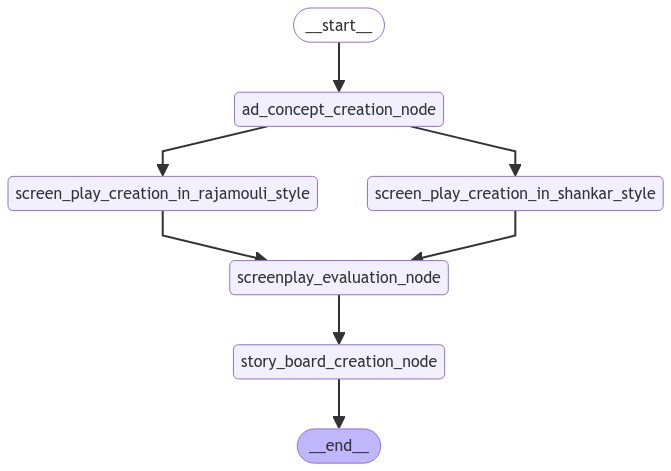

In [12]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

Let's create the story boarding

In [18]:
graph_input = {"theme": """Create an ad for a modern trimmer with characters from Bahubali"""}

for output in app.stream(graph_input, stream_mode="values"):
    pass

------ENTERING: AD CONCEPT CREATION NODE------


**CONCEPT 1:**

<font color="navy">### Ad Concept: "The Royal Trim - Bahubali Edition"

**Title:** "Unleash the Warrior Within"

**Characters:** Amarendra Baahubali, Bhallaladeva, Devasena, Sivagami

**Setting:** The majestic kingdom of Mahishmati

**Plot:**

The ad opens with a grand aerial view of the kingdom of Mahishmati, showcasing its grandeur and splendor. The camera zooms into the royal palace where Amarendra Baahubali (played by Prabhas) is seen preparing for a grand ceremony. His hair and beard are perfectly groomed, exuding an aura of regality and strength.

**Scene 1: The Royal Preparation**

Amarendra Baahubali stands in front of a mirror, holding the modern trimmer. The trimmer has a sleek design with a metallic finish, reflecting the royal aesthetics. As he trims his beard, the voiceover says, "In the kingdom of Mahishmati, every warrior must look his best."

**Scene 2: The Rival's Envy**

Cut to Bhallaladeva (played by Rana Daggubati) watching Baahubali from a distance. He clenches his fist in envy but is also seen using the same trimmer to groom his beard. The voiceover continues, "Even the fiercest rivals know the power of a well-groomed appearance."

**Scene 3: The Queen's Approval**

Devasena (played by Anushka Shetty) enters the scene, admiring Baahubali's groomed look. She smiles and says, "A true king is not just known by his valor but also by his appearance." She hands the trimmer to Sivagami (played by Ramya Krishnan), who nods in approval.

**Scene 4: The Battle Ready**

The final scene shows Baahubali leading his army, looking sharp and battle-ready. The camera focuses on the trimmer, now placed on a royal pedestal. The voiceover concludes, "Unleash the warrior within. The Royal Trim - Bahubali Edition. For the kings of today."

**Tagline:** "The Royal Trim - Bahubali Edition. For the kings of today."

**Justification:**

1. **Character Appeal:** Using iconic characters from Bahubali ensures instant recognition and emotional connection with the audience.
2. **Royal Aesthetics:** The grandeur of Mahishmati and the royal characters align perfectly with the premium feel of the modern trimmer.
3. **Narrative:** The storyline emphasizes the importance of grooming, not just for appearance but as a symbol of strength and leadership.
4. **Cultural Relevance:** Bahubali is a cultural phenomenon in India, and associating a product with it leverages its massive fan base.
5. **Visual Impact:** The majestic setting and powerful characters create a visually stunning ad that captures attention.

This ad concept combines the timeless appeal of Bahubali with the modern necessity of grooming, making it a compelling and memorable advertisement.</font>

------ENTERING: SCREEN PLAY CREATION NODE 1: In SS Rajamouli Style------------ENTERING: SCREEN PLAY CREATION NODE 2: In Shankar Style------



**SCREENPLAY 2: In Shankar Style:**

<font color="green">**Title:** "Unleash the Warrior Within"

**Genre:** Historical Drama with Modern Twist

**Setting:** The majestic kingdom of Mahishmati, blending ancient grandeur with modern elements.

**Characters:**
1. **Amarendra Baahubali** - The noble and valiant king, known for his strength and leadership.
2. **Bhallaladeva** - The envious rival, equally powerful but driven by jealousy.
3. **Devasena** - The graceful and wise queen, who values both valor and appearance.
4. **Sivagami** - The regal and authoritative queen mother, whose approval is paramount.

**Plot Overview:**
The ad showcases the importance of grooming in the lives of the royal characters from Bahubali. It emphasizes that even the mightiest warriors and leaders need to look their best, using the modern trimmer to maintain their regal appearance.

**Scenes:**

**Opening Scene: The Royal Preparation**

*Visuals:* A grand aerial view of Mahishmati, with its towering palaces and bustling streets. The camera zooms into the royal palace, focusing on the opulent interiors.

*Action:* Amarendra Baahubali stands in front of a mirror, holding the modern trimmer. He carefully trims his beard, exuding confidence and regality.

*Camera Transition:* The camera pans from a wide shot of the palace to a close-up of Baahubali's face, highlighting his perfectly groomed beard.

*Close-Up:* A close-up shot of the trimmer in Baahubali's hand, showcasing its sleek design and metallic finish.

*Text on Screen:* "In the kingdom of Mahishmati, every warrior must look his best."

**Middle Scene 1: The Rival's Envy**

*Visuals:* Bhallaladeva watches Baahubali from a distance, his face contorted with envy. The camera captures the tension in his eyes.

*Action:* Bhallaladeva clenches his fist but then picks up the same trimmer to groom his beard, acknowledging its power.

*Camera Transition:* A slow zoom from Bhallaladeva's face to the trimmer in his hand.

*Close-Up:* A close-up of Bhallaladeva's face as he uses the trimmer, showing his transformation.

*Text on Screen:* "Even the fiercest rivals know the power of a well-groomed appearance."

**Middle Scene 2: The Queen's Approval**

*Visuals:* Devasena enters the scene, her eyes filled with admiration as she looks at Baahubali. The palace's grandeur is evident in the background.

*Action:* Devasena smiles and says, "A true king is not just known by his valor but also by his appearance." She hands the trimmer to Sivagami.

*Camera Transition:* A smooth pan from Devasena to Sivagami, capturing their expressions.

*Close-Up:* A close-up of Sivagami nodding in approval, holding the trimmer.

*Text on Screen:* "A true king is not just known by his valor but also by his appearance."

**Climactic Scene: The Battle Ready**

*Visuals:* Baahubali leads his army, looking sharp and battle-ready. The scene is filled with the energy of an impending battle.

*Action:* The camera follows Baahubali as he marches forward, his army behind him. The trimmer is placed on a royal pedestal, gleaming in the sunlight.

*Camera Transition:* A dynamic shot from Baahubali's face to the trimmer on the pedestal.

*Close-Up:* A close-up of the trimmer, highlighting its features and design.

*Text on Screen:* "Unleash the warrior within. The Royal Trim - Bahubali Edition. For the kings of today."

**Ending Scene: The Legacy Continues**

*Visuals:* The camera captures the majestic kingdom of Mahishmati one last time, with the royal palace in the background.

*Action:* Baahubali, Bhallaladeva, Devasena, and Sivagami stand together, united in their regal appearance.

*Camera Transition:* A wide shot of the royal family, transitioning to a close-up of the trimmer.

*Close-Up:* The trimmer, now a symbol of royal grooming, shines brightly.

*Text on Screen:* "The Royal Trim - Bahubali Edition. For the kings of today."

**Tagline:** "The Royal Trim - Bahubali Edition. For the kings of today."

**Justification:**

1. **Character Appeal:** Using iconic characters from Bahubali ensures instant recognition and emotional connection with the audience.
2. **Royal Aesthetics:** The grandeur of Mahishmati and the royal characters align perfectly with the premium feel of the modern trimmer.
3. **Narrative:** The storyline emphasizes the importance of grooming, not just for appearance but as a symbol of strength and leadership.
4. **Cultural Relevance:** Bahubali is a cultural phenomenon in India, and associating a product with it leverages its massive fan base.
5. **Visual Impact:** The majestic setting and powerful characters create a visually stunning ad that captures attention.

This ad concept combines the timeless appeal of Bahubali with the modern necessity of grooming, making it a compelling and memorable advertisement.</font>

**SCREENPLAY 1: In SS Rajamouli Style**

<font color="blue">**Title:** "Unleash the Warrior Within"

**Genre:** Epic Fantasy

**Setting:** The majestic kingdom of Mahishmati, a blend of ancient grandeur and modern elegance.

**Characters:**
- **Amarendra Baahubali:** The noble and valiant prince, known for his strength and leadership.
- **Bhallaladeva:** The envious and ambitious rival, always striving to outshine Baahubali.
- **Devasena:** The graceful and wise queen, who values both valor and appearance.
- **Sivagami:** The regal and authoritative queen mother, whose approval is paramount.

**Plot Overview:**
In the kingdom of Mahishmati, appearance is as important as valor. The story follows Amarendra Baahubali as he prepares for a grand ceremony, showcasing the importance of grooming in a warrior's life. Bhallaladeva, driven by envy, also uses the same trimmer, highlighting its universal appeal. Devasena and Sivagami's approval further cements the trimmer's royal status. The ad concludes with Baahubali leading his army, embodying the essence of a true king.

**Scenes:**

**Scene 1: The Royal Preparation**

*Visuals:* A grand aerial view of Mahishmati, with its towering palaces and bustling streets. The camera zooms into the royal palace, focusing on Baahubali's chamber.

*Action:* Baahubali stands in front of an ornate mirror, holding the modern trimmer. He meticulously trims his beard, exuding confidence and regality.

*Camera Transition:* The camera pans from Baahubali's reflection to a close-up of the trimmer, highlighting its sleek design.

*Close-Up:* A close-up of Baahubali's face, showing his perfectly groomed beard.

*Text on Screen:* "In the kingdom of Mahishmati, every warrior must look his best."

**Scene 2: The Rival's Envy**

*Visuals:* Bhallaladeva's chamber, filled with weapons and trophies. He watches Baahubali from a distance, his eyes filled with envy.

*Action:* Bhallaladeva clenches his fist but then picks up the same trimmer to groom his beard, acknowledging its power.

*Camera Transition:* The camera shifts from Bhallaladeva's intense gaze to a close-up of him using the trimmer.

*Close-Up:* A close-up of Bhallaladeva's face, showing his groomed look.

*Text on Screen:* "Even the fiercest rivals know the power of a well-groomed appearance."

**Scene 3: The Queen's Approval**

*Visuals:* The royal garden, with blooming flowers and serene fountains. Devasena walks gracefully towards Baahubali.

*Action:* Devasena admires Baahubali's groomed look and smiles. She hands the trimmer to Sivagami, who nods in approval.

*Camera Transition:* The camera follows Devasena's movement, focusing on her expression and then shifting to Sivagami.

*Close-Up:* A close-up of Sivagami's approving nod.

*Text on Screen:* "A true king is not just known by his valor but also by his appearance."

**Scene 4: The Battle Ready**

*Visuals:* The battlefield, with Baahubali leading his army. The soldiers are in perfect formation, ready for battle.

*Action:* Baahubali, looking sharp and battle-ready, raises his sword, inspiring his troops.

*Camera Transition:* The camera moves from the army to a close-up of Baahubali, then to the trimmer placed on a royal pedestal.

*Close-Up:* A close-up of the trimmer on the pedestal, shining under the sunlight.

*Text on Screen:* "Unleash the warrior within. The Royal Trim - Bahubali Edition. For the kings of today."

**Tagline:** "The Royal Trim - Bahubali Edition. For the kings of today."

**Justification:**

1. **Character Appeal:** Using iconic characters from Bahubali ensures instant recognition and emotional connection with the audience.
2. **Royal Aesthetics:** The grandeur of Mahishmati and the royal characters align perfectly with the premium feel of the modern trimmer.
3. **Narrative:** The storyline emphasizes the importance of grooming, not just for appearance but as a symbol of strength and leadership.
4. **Cultural Relevance:** Bahubali is a cultural phenomenon in India, and associating a product with it leverages its massive fan base.
5. **Visual Impact:** The majestic setting and powerful characters create a visually stunning ad that captures attention.

This ad concept combines the timeless appeal of Bahubali with the modern necessity of grooming, making it a compelling and memorable advertisement.</font>

---------------------------------

Which screenplay did you like and proceed with?

1. Rajamouli 
2. Shankar 

Please enter 1 or 2!2


**SCREENPLAY WINNER:** <font color="red">[screenplay_2]</font>

<font color="red">**Title:** "Unleash the Warrior Within"

**Genre:** Historical Drama with Modern Twist

**Setting:** The majestic kingdom of Mahishmati, blending ancient grandeur with modern elements.

**Characters:**
1. **Amarendra Baahubali** - The noble and valiant king, known for his strength and leadership.
2. **Bhallaladeva** - The envious rival, equally powerful but driven by jealousy.
3. **Devasena** - The graceful and wise queen, who values both valor and appearance.
4. **Sivagami** - The regal and authoritative queen mother, whose approval is paramount.

**Plot Overview:**
The ad showcases the importance of grooming in the lives of the royal characters from Bahubali. It emphasizes that even the mightiest warriors and leaders need to look their best, using the modern trimmer to maintain their regal appearance.

**Scenes:**

**Opening Scene: The Royal Preparation**

*Visuals:* A grand aerial view of Mahishmati, with its towering palaces and bustling streets. The camera zooms into the royal palace, focusing on the opulent interiors.

*Action:* Amarendra Baahubali stands in front of a mirror, holding the modern trimmer. He carefully trims his beard, exuding confidence and regality.

*Camera Transition:* The camera pans from a wide shot of the palace to a close-up of Baahubali's face, highlighting his perfectly groomed beard.

*Close-Up:* A close-up shot of the trimmer in Baahubali's hand, showcasing its sleek design and metallic finish.

*Text on Screen:* "In the kingdom of Mahishmati, every warrior must look his best."

**Middle Scene 1: The Rival's Envy**

*Visuals:* Bhallaladeva watches Baahubali from a distance, his face contorted with envy. The camera captures the tension in his eyes.

*Action:* Bhallaladeva clenches his fist but then picks up the same trimmer to groom his beard, acknowledging its power.

*Camera Transition:* A slow zoom from Bhallaladeva's face to the trimmer in his hand.

*Close-Up:* A close-up of Bhallaladeva's face as he uses the trimmer, showing his transformation.

*Text on Screen:* "Even the fiercest rivals know the power of a well-groomed appearance."

**Middle Scene 2: The Queen's Approval**

*Visuals:* Devasena enters the scene, her eyes filled with admiration as she looks at Baahubali. The palace's grandeur is evident in the background.

*Action:* Devasena smiles and says, "A true king is not just known by his valor but also by his appearance." She hands the trimmer to Sivagami.

*Camera Transition:* A smooth pan from Devasena to Sivagami, capturing their expressions.

*Close-Up:* A close-up of Sivagami nodding in approval, holding the trimmer.

*Text on Screen:* "A true king is not just known by his valor but also by his appearance."

**Climactic Scene: The Battle Ready**

*Visuals:* Baahubali leads his army, looking sharp and battle-ready. The scene is filled with the energy of an impending battle.

*Action:* The camera follows Baahubali as he marches forward, his army behind him. The trimmer is placed on a royal pedestal, gleaming in the sunlight.

*Camera Transition:* A dynamic shot from Baahubali's face to the trimmer on the pedestal.

*Close-Up:* A close-up of the trimmer, highlighting its features and design.

*Text on Screen:* "Unleash the warrior within. The Royal Trim - Bahubali Edition. For the kings of today."

**Ending Scene: The Legacy Continues**

*Visuals:* The camera captures the majestic kingdom of Mahishmati one last time, with the royal palace in the background.

*Action:* Baahubali, Bhallaladeva, Devasena, and Sivagami stand together, united in their regal appearance.

*Camera Transition:* A wide shot of the royal family, transitioning to a close-up of the trimmer.

*Close-Up:* The trimmer, now a symbol of royal grooming, shines brightly.

*Text on Screen:* "The Royal Trim - Bahubali Edition. For the kings of today."

**Tagline:** "The Royal Trim - Bahubali Edition. For the kings of today."

**Justification:**

1. **Character Appeal:** Using iconic characters from Bahubali ensures instant recognition and emotional connection with the audience.
2. **Royal Aesthetics:** The grandeur of Mahishmati and the royal characters align perfectly with the premium feel of the modern trimmer.
3. **Narrative:** The storyline emphasizes the importance of grooming, not just for appearance but as a symbol of strength and leadership.
4. **Cultural Relevance:** Bahubali is a cultural phenomenon in India, and associating a product with it leverages its massive fan base.
5. **Visual Impact:** The majestic setting and powerful characters create a visually stunning ad that captures attention.

This ad concept combines the timeless appeal of Bahubali with the modern necessity of grooming, making it a compelling and memorable advertisement.</font>

------ENTERING: STORY BOARD CREATION NODE------


A grand aerial view of Mahishmati, with its towering palaces and bustling streets. The camera zooms into the royal palace, focusing on the opulent interiors. Amarendra Baahubali stands in front of a mirror, holding the modern trimmer. He carefully trims his beard, exuding confidence and regality. The camera pans from a wide shot of the palace to a close-up of Baahubali's face, highlighting his perfectly groomed beard. Close-up shot of the trimmer in Baahubali's hand, showcasing its sleek design and metallic finish. Text on Screen: 'In the kingdom of Mahishmati, every warrior must look his best.' gen_id=yRmG5bW4bmcfWbVP seed=12345

----------------------

Bhallaladeva watches Baahubali from a distance, his face contorted with envy. The camera captures the tension in his eyes. Bhallaladeva clenches his fist but then picks up the same trimmer to groom his beard, acknowledging its power. A slow zoom from Bhallaladeva's face to the trimmer in his hand. Close-up of Bhallaladeva's face as he uses the trimmer, showing his transformation. Text on Screen: 'Even the fiercest rivals know the power of a well-groomed appearance.' gen_id=yRmG5bW4bmcfWbVP seed=12345

----------------------

Devasena enters the scene, her eyes filled with admiration as she looks at Baahubali. The palace's grandeur is evident in the background. Devasena smiles and says, 'A true king is not just known by his valor but also by his appearance.' She hands the trimmer to Sivagami. A smooth pan from Devasena to Sivagami, capturing their expressions. Close-up of Sivagami nodding in approval, holding the trimmer. Text on Screen: 'A true king is not just known by his valor but also by his appearance.' gen_id=yRmG5bW4bmcfWbVP seed=12345

----------------------

Baahubali leads his army, looking sharp and battle-ready. The scene is filled with the energy of an impending battle. The camera follows Baahubali as he marches forward, his army behind him. The trimmer is placed on a royal pedestal, gleaming in the sunlight. A dynamic shot from Baahubali's face to the trimmer on the pedestal. Close-up of the trimmer, highlighting its features and design. Text on Screen: 'Unleash the warrior within. The Royal Trim - Bahubali Edition. For the kings of today.' gen_id=yRmG5bW4bmcfWbVP seed=12345

----------------------

The camera captures the majestic kingdom of Mahishmati one last time, with the royal palace in the background. Baahubali, Bhallaladeva, Devasena, and Sivagami stand together, united in their regal appearance. A wide shot of the royal family, transitioning to a close-up of the trimmer. The trimmer, now a symbol of royal grooming, shines brightly. Text on Screen: 'The Royal Trim - Bahubali Edition. For the kings of today.' gen_id=yRmG5bW4bmcfWbVP seed=12345

----------------------

In [14]:
graph_input = {"theme": """Create an ad for smart pacifier in a time travel theme"""}

for output in app.stream(graph_input, stream_mode="values"):
    pass

------ENTERING: AD CONCEPT CREATION NODE------


**CONCEPT 1:**

<font color="navy">### Ad Concept: "The Time-Traveling Smart Pacifier: A Journey Through Your Baby's Future"

#### Visuals:
1. **Opening Scene**: A serene nursery with a baby sleeping peacefully. The camera zooms in on a futuristic-looking smart pacifier glowing softly in the baby's mouth.
2. **Transition**: The room starts to shimmer and transform, showing different stages of the baby's life—first steps, first day of school, graduation, and beyond.
3. **Time Travel Effect**: Each stage is connected by a swirling, magical time-travel effect, emphasizing the seamless journey through time.
4. **Final Scene**: The baby, now a healthy and happy adult, smiles at the camera, holding the same smart pacifier as a keepsake.

#### Script:
**Narrator**: "Imagine a pacifier that not only soothes your baby today but also safeguards their future. Introducing the Time-Traveling Smart Pacifier."

**Cut to scenes of the pacifier in different stages of the child's life.**

**Narrator**: "With real-time health monitoring, temperature regulation, and sleep pattern analysis, this smart pacifier ensures your baby's well-being at every stage."

**Show the pacifier sending data to a parent's smartphone, with notifications about the baby's health.**

**Narrator**: "It's like having a time machine that lets you see into your baby's future, ensuring they grow up healthy and happy."

**Final Scene**: The adult child holds the pacifier, smiling. The screen fades to the product and brand logo.

**Narrator**: "The Time-Traveling Smart Pacifier—because every moment counts."

#### Justification:
1. **Emotional Connection**: The ad taps into the deep emotional bond parents have with their children, emphasizing the importance of their child's future.
2. **Innovative Technology**: By showcasing the advanced features of the smart pacifier, the ad highlights its unique selling points, making it stand out in the market.
3. **Time Travel Theme**: The time-travel concept is visually engaging and metaphorically powerful, suggesting that this pacifier is an investment in the child's future.
4. **Market Trends**: The ad aligns with current trends in health and wellness, appealing to millennial parents who prioritize their child's well-being.

This concept not only captures attention but also resonates with the target audience, making it a memorable and effective advertisement.</font>

------ENTERING: SCREEN PLAY CREATION NODE 1: In SS Rajamouli Style------
------ENTERING: SCREEN PLAY CREATION NODE 2: In Shankar Style------


**SCREENPLAY 2: In Shankar Style:**

<font color="green">### Title: "The Time-Traveling Smart Pacifier: A Journey Through Your Baby's Future"

### Genre: Sci-Fi Drama

### Setting:
- **Primary Locations**: A modern nursery, various stages of a child's life (home, school, graduation ceremony, etc.)
- **Time Periods**: Present day, near future, and distant future

### Characters:
- **Baby**: The central character, representing the journey from infancy to adulthood.
- **Parents**: Loving and attentive, they represent the emotional connection and concern for the baby's future.
- **Narrator**: A warm, reassuring voice guiding the audience through the journey.

### Plot Overview:
The ad follows the journey of a baby from infancy to adulthood, showcasing the smart pacifier's role in ensuring the baby's health and well-being at every stage. The pacifier's advanced features are highlighted through a time-traveling narrative, emphasizing its impact on the child's future.

### Scenes:

#### Opening Scene:
- **Visuals**: A serene nursery with soft, warm lighting. The baby sleeps peacefully in a crib, with a futuristic-looking smart pacifier glowing softly in their mouth.
- **Action**: The camera zooms in on the pacifier, capturing its gentle glow.
- **Camera Transition**: The room starts to shimmer and transform, indicating the beginning of a time-travel journey.
- **Close-Up**: A close-up shot of the pacifier as the room changes around it.
- **Text on Screen**: "Imagine a pacifier that not only soothes your baby today but also safeguards their future."

#### Middle Scenes:

##### Scene 1: First Steps
- **Visuals**: The baby, now a toddler, takes their first steps in a living room filled with toys.
- **Action**: The pacifier, still in the toddler's mouth, glows as it monitors their health.
- **Camera Transition**: A swirling, magical time-travel effect connects this scene to the next.
- **Close-Up**: The pacifier sending data to a parent's smartphone.
- **Text on Screen**: "Real-time health monitoring."

##### Scene 2: First Day of School
- **Visuals**: The child, now a young student, walks into a school building, holding a parent's hand.
- **Action**: The pacifier, now a keepsake in the child's backpack, continues to glow softly.
- **Camera Transition**: Another time-travel effect as the scene shifts to the next stage.
- **Close-Up**: The pacifier's glow reflecting in the child's eyes.
- **Text on Screen**: "Temperature regulation."

##### Scene 3: Graduation
- **Visuals**: The child, now a teenager, stands on a stage in a graduation gown, receiving their diploma.
- **Action**: The pacifier, now a cherished memento, is held by the proud parents in the audience.
- **Camera Transition**: A final time-travel effect leading to the climactic scene.
- **Close-Up**: The pacifier in the parents' hands.
- **Text on Screen**: "Sleep pattern analysis."

#### Climactic Scene:
- **Visuals**: The baby, now a healthy and happy adult, smiles at the camera, holding the same smart pacifier as a keepsake.
- **Action**: The adult reflects on their journey, with flashbacks to key moments.
- **Camera Transition**: A smooth transition from the past to the present, showing the continuity of care.
- **Close-Up**: The adult's smile and the pacifier in their hand.
- **Text on Screen**: "Ensuring your baby's well-being at every stage."

#### Ending Scene:
- **Visuals**: The screen fades to the product and brand logo.
- **Action**: The narrator's voice provides a final, reassuring message.
- **Close-Up**: The brand logo and the pacifier.
- **Text on Screen**: "The Time-Traveling Smart Pacifier—because every moment counts."

### Dialogue:

**Narrator**: "Imagine a pacifier that not only soothes your baby today but also safeguards their future. Introducing the Time-Traveling Smart Pacifier."

**Cut to scenes of the pacifier in different stages of the child's life.**

**Narrator**: "With real-time health monitoring, temperature regulation, and sleep pattern analysis, this smart pacifier ensures your baby's well-being at every stage."

**Show the pacifier sending data to a parent's smartphone, with notifications about the baby's health.**

**Narrator**: "It's like having a time machine that lets you see into your baby's future, ensuring they grow up healthy and happy."

**Final Scene**: The adult child holds the pacifier, smiling. The screen fades to the product and brand logo.

**Narrator**: "The Time-Traveling Smart Pacifier—because every moment counts."

### Additional Notes:
- The ad taps into the deep emotional bond parents have with their children, emphasizing the importance of their child's future.
- By showcasing the advanced features of the smart pacifier, the ad highlights its unique selling points, making it stand out in the market.
- The time-travel concept is visually engaging and metaphorically powerful, suggesting that this pacifier is an investment in the child's future.
- The ad aligns with current trends in health and wellness, appealing to millennial parents who prioritize their child's well-being.</font>

**SCREENPLAY 1: In SS Rajamouli Style**

<font color="blue">### Title: "The Time-Traveling Smart Pacifier: A Journey Through Your Baby's Future"

### Genre: Fantasy, Drama

### Setting:
- **Primary Locations**: A serene nursery, various stages of a child's life (home, school, graduation ceremony, etc.), and a futuristic setting.
- **Time Periods**: Present day, near future, and distant future.

### Characters:
- **Baby**: The central character, representing the journey from infancy to adulthood.
- **Parents**: Loving and caring, always present in the background, symbolizing support and guidance.
- **Narrator**: A warm, reassuring voice guiding the audience through the journey.

### Plot Overview:
The ad follows the journey of a baby from infancy to adulthood, showcasing the smart pacifier's role in ensuring the child's well-being at every stage. The pacifier, equipped with advanced features, acts as a guardian, providing real-time health monitoring and comfort. The time-travel theme visually connects different life stages, emphasizing the pacifier's lasting impact.

### Scenes:

#### Opening Scene:
- **Visuals**: A serene nursery with soft, warm lighting. The baby sleeps peacefully in a crib, with a futuristic-looking smart pacifier glowing softly in their mouth.
- **Action**: The camera zooms in on the pacifier, highlighting its sleek design and gentle glow.
- **Camera Transition**: The room starts to shimmer and transform, indicating the beginning of a time-travel journey.
- **Close-Up**: A close-up of the pacifier in the baby's mouth, emphasizing its importance.
- **Text on Screen**: "Imagine a pacifier that not only soothes your baby today but also safeguards their future."

#### Middle Scenes:
1. **First Steps**:
   - **Visuals**: The baby, now a toddler, takes their first steps in a cozy living room.
   - **Action**: The pacifier, still glowing, is clipped to the toddler's shirt. Parents cheer in the background.
   - **Camera Transition**: A swirling, magical time-travel effect connects this scene to the next.
   - **Close-Up**: The pacifier sending data to a parent's smartphone, showing health stats.
   - **Text on Screen**: "With real-time health monitoring..."

2. **First Day of School**:
   - **Visuals**: The child, now a young student, walks into a school building, holding a backpack.
   - **Action**: The pacifier, now a keepsake, is attached to the backpack.
   - **Camera Transition**: Another time-travel effect, transitioning to the next stage.
   - **Close-Up**: The pacifier's data being reviewed by parents on their phone.
   - **Text on Screen**: "...temperature regulation..."

3. **Graduation**:
   - **Visuals**: The child, now a teenager, stands on a stage in a graduation gown, receiving a diploma.
   - **Action**: The pacifier, still a cherished keepsake, is in the teenager's hand.
   - **Camera Transition**: A final time-travel effect, leading to the climactic scene.
   - **Close-Up**: The pacifier's data history, showing years of health monitoring.
   - **Text on Screen**: "...and sleep pattern analysis."

#### Climactic Scene:
- **Visuals**: The baby, now a healthy and happy adult, stands in a futuristic setting, smiling at the camera.
- **Action**: The adult holds the same smart pacifier as a keepsake, symbolizing its lasting impact.
- **Camera Transition**: A slow zoom out, showing the adult surrounded by loved ones.
- **Close-Up**: The pacifier in the adult's hand, glowing softly.
- **Text on Screen**: "It's like having a time machine that lets you see into your baby's future, ensuring they grow up healthy and happy."

#### Ending Scene:
- **Visuals**: The screen fades to the product and brand logo.
- **Action**: The narrator's voice concludes the ad.
- **Text on Screen**: "The Time-Traveling Smart Pacifier—because every moment counts."

### Dialogue:
**Narrator**: "Imagine a pacifier that not only soothes your baby today but also safeguards their future. Introducing the Time-Traveling Smart Pacifier."

**Cut to scenes of the pacifier in different stages of the child's life.**

**Narrator**: "With real-time health monitoring, temperature regulation, and sleep pattern analysis, this smart pacifier ensures your baby's well-being at every stage."

**Show the pacifier sending data to a parent's smartphone, with notifications about the baby's health.**

**Narrator**: "It's like having a time machine that lets you see into your baby's future, ensuring they grow up healthy and happy."

**Final Scene**: The adult child holds the pacifier, smiling. The screen fades to the product and brand logo.

**Narrator**: "The Time-Traveling Smart Pacifier—because every moment counts."

### Additional Notes:
- The ad taps into the deep emotional bond parents have with their children, emphasizing the importance of their child's future.
- By showcasing the advanced features of the smart pacifier, the ad highlights its unique selling points, making it stand out in the market.
- The time-travel concept is visually engaging and metaphorically powerful, suggesting that this pacifier is an investment in the child's future.
- The ad aligns with current trends in health and wellness, appealing to millennial parents who prioritize their child's well-being.</font>

---------------------------------

Which screenplay did you like and proceed with?

1. Rajamouli 
2. Shankar 

Please enter 1 or 2!2


**SCREENPLAY WINNER:** <font color="red">[screenplay_2]</font>

<font color="red">### Title: "The Time-Traveling Smart Pacifier: A Journey Through Your Baby's Future"

### Genre: Sci-Fi Drama

### Setting:
- **Primary Locations**: A modern nursery, various stages of a child's life (home, school, graduation ceremony, etc.)
- **Time Periods**: Present day, near future, and distant future

### Characters:
- **Baby**: The central character, representing the journey from infancy to adulthood.
- **Parents**: Loving and attentive, they represent the emotional connection and concern for the baby's future.
- **Narrator**: A warm, reassuring voice guiding the audience through the journey.

### Plot Overview:
The ad follows the journey of a baby from infancy to adulthood, showcasing the smart pacifier's role in ensuring the baby's health and well-being at every stage. The pacifier's advanced features are highlighted through a time-traveling narrative, emphasizing its impact on the child's future.

### Scenes:

#### Opening Scene:
- **Visuals**: A serene nursery with soft, warm lighting. The baby sleeps peacefully in a crib, with a futuristic-looking smart pacifier glowing softly in their mouth.
- **Action**: The camera zooms in on the pacifier, capturing its gentle glow.
- **Camera Transition**: The room starts to shimmer and transform, indicating the beginning of a time-travel journey.
- **Close-Up**: A close-up shot of the pacifier as the room changes around it.
- **Text on Screen**: "Imagine a pacifier that not only soothes your baby today but also safeguards their future."

#### Middle Scenes:

##### Scene 1: First Steps
- **Visuals**: The baby, now a toddler, takes their first steps in a living room filled with toys.
- **Action**: The pacifier, still in the toddler's mouth, glows as it monitors their health.
- **Camera Transition**: A swirling, magical time-travel effect connects this scene to the next.
- **Close-Up**: The pacifier sending data to a parent's smartphone.
- **Text on Screen**: "Real-time health monitoring."

##### Scene 2: First Day of School
- **Visuals**: The child, now a young student, walks into a school building, holding a parent's hand.
- **Action**: The pacifier, now a keepsake in the child's backpack, continues to glow softly.
- **Camera Transition**: Another time-travel effect as the scene shifts to the next stage.
- **Close-Up**: The pacifier's glow reflecting in the child's eyes.
- **Text on Screen**: "Temperature regulation."

##### Scene 3: Graduation
- **Visuals**: The child, now a teenager, stands on a stage in a graduation gown, receiving their diploma.
- **Action**: The pacifier, now a cherished memento, is held by the proud parents in the audience.
- **Camera Transition**: A final time-travel effect leading to the climactic scene.
- **Close-Up**: The pacifier in the parents' hands.
- **Text on Screen**: "Sleep pattern analysis."

#### Climactic Scene:
- **Visuals**: The baby, now a healthy and happy adult, smiles at the camera, holding the same smart pacifier as a keepsake.
- **Action**: The adult reflects on their journey, with flashbacks to key moments.
- **Camera Transition**: A smooth transition from the past to the present, showing the continuity of care.
- **Close-Up**: The adult's smile and the pacifier in their hand.
- **Text on Screen**: "Ensuring your baby's well-being at every stage."

#### Ending Scene:
- **Visuals**: The screen fades to the product and brand logo.
- **Action**: The narrator's voice provides a final, reassuring message.
- **Close-Up**: The brand logo and the pacifier.
- **Text on Screen**: "The Time-Traveling Smart Pacifier—because every moment counts."

### Dialogue:

**Narrator**: "Imagine a pacifier that not only soothes your baby today but also safeguards their future. Introducing the Time-Traveling Smart Pacifier."

**Cut to scenes of the pacifier in different stages of the child's life.**

**Narrator**: "With real-time health monitoring, temperature regulation, and sleep pattern analysis, this smart pacifier ensures your baby's well-being at every stage."

**Show the pacifier sending data to a parent's smartphone, with notifications about the baby's health.**

**Narrator**: "It's like having a time machine that lets you see into your baby's future, ensuring they grow up healthy and happy."

**Final Scene**: The adult child holds the pacifier, smiling. The screen fades to the product and brand logo.

**Narrator**: "The Time-Traveling Smart Pacifier—because every moment counts."

### Additional Notes:
- The ad taps into the deep emotional bond parents have with their children, emphasizing the importance of their child's future.
- By showcasing the advanced features of the smart pacifier, the ad highlights its unique selling points, making it stand out in the market.
- The time-travel concept is visually engaging and metaphorically powerful, suggesting that this pacifier is an investment in the child's future.
- The ad aligns with current trends in health and wellness, appealing to millennial parents who prioritize their child's well-being.</font>

------ENTERING: STORY BOARD CREATION NODE------


A serene nursery with soft, warm lighting. The baby sleeps peacefully in a crib, with a futuristic-looking smart pacifier glowing softly in their mouth. The camera zooms in on the pacifier, capturing its gentle glow. The room starts to shimmer and transform, indicating the beginning of a time-travel journey. Close-up shot of the pacifier as the room changes around it. Text on screen: 'Imagine a pacifier that not only soothes your baby today but also safeguards their future.' gen_id=yRmG5bW4bmcfWbVP seed=12345

----------------------

The baby, now a toddler, takes their first steps in a living room filled with toys. The pacifier, still in the toddler's mouth, glows as it monitors their health. A swirling, magical time-travel effect connects this scene to the next. Close-up of the pacifier sending data to a parent's smartphone. Text on screen: 'Real-time health monitoring.' gen_id=yRmG5bW4bmcfWbVP seed=12345

----------------------

The child, now a young student, walks into a school building, holding a parent's hand. The pacifier, now a keepsake in the child's backpack, continues to glow softly. Another time-travel effect as the scene shifts to the next stage. Close-up of the pacifier's glow reflecting in the child's eyes. Text on screen: 'Temperature regulation.' gen_id=yRmG5bW4bmcfWbVP seed=12345

----------------------

The child, now a teenager, stands on a stage in a graduation gown, receiving their diploma. The pacifier, now a cherished memento, is held by the proud parents in the audience. A final time-travel effect leading to the climactic scene. Close-up of the pacifier in the parents' hands. Text on screen: 'Sleep pattern analysis.' gen_id=yRmG5bW4bmcfWbVP seed=12345

----------------------

The baby, now a healthy and happy adult, smiles at the camera, holding the same smart pacifier as a keepsake. The adult reflects on their journey, with flashbacks to key moments. A smooth transition from the past to the present, showing the continuity of care. Close-up of the adult's smile and the pacifier in their hand. Text on screen: 'Ensuring your baby's well-being at every stage.' gen_id=yRmG5bW4bmcfWbVP seed=12345

----------------------

The screen fades to the product and brand logo. The narrator's voice provides a final, reassuring message. Close-up of the brand logo and the pacifier. Text on screen: 'The Time-Traveling Smart Pacifier—because every moment counts.' gen_id=yRmG5bW4bmcfWbVP seed=12345

----------------------

In [ ]:
graph_input = {"theme": """Create an ad for the volkswagen taigun car"""}

for output in app.stream(graph_input, stream_mode="values"):
    pass

------ENTERING: AD CONCEPT CREATION NODE------


**CONCEPT 1:**

<font color="navy">### Ad Concept: "Unleash the Urban Explorer in You"

#### Visuals:
1. **Opening Scene**: A bustling cityscape at dawn, with the first light reflecting off skyscrapers. The camera zooms in on the Volkswagen Taigun parked stylishly on a quiet street.
2. **Transition**: The Taigun starts, and the city comes to life. The car navigates through the urban jungle with ease, showcasing its sleek design and agility.
3. **Interior Shots**: Close-ups of the 10.25-inch touchscreen infotainment system, digital instrument cluster, and the electric sunroof opening to let in the morning sun.
4. **Family and Friends**: Scenes of a family and friends enjoying the spacious interior, connecting their devices via Apple CarPlay and Android Auto, and sharing moments of joy.
5. **Adventure Mode**: The Taigun transitions from city streets to a scenic countryside, demonstrating its versatility and performance on different terrains.
6. **Closing Scene**: The car parks at a picturesque location, with the tagline appearing on the screen.

#### Tagline:
"Volkswagen Taigun - Unleash the Urban Explorer in You"

#### Voiceover Script:
"Introducing the Volkswagen Taigun, your perfect companion for the urban jungle and beyond. With its modern design, advanced technology, and unmatched versatility, the Taigun is built for those who seek adventure in every journey. Experience the freedom to explore, the comfort to enjoy, and the power to conquer. Volkswagen Taigun - Unleash the Urban Explorer in You."

#### Justification:
1. **Target Audience**: The ad targets urban dwellers who value style, technology, and versatility in their vehicles. It appeals to both families and young professionals.
2. **Features Highlighted**: The ad showcases key features such as the 10.25-inch touchscreen infotainment system, digital instrument cluster, electric sunroof, and connectivity options, which are major selling points for tech-savvy consumers.
3. **Emotional Connection**: By depicting moments of joy and adventure, the ad creates an emotional connection with the audience, emphasizing the Taigun as a vehicle that enhances life experiences.
4. **Current Trends**: The ad leverages the latest trends in automotive marketing, such as digital connectivity, lifestyle integration, and the shift towards versatile, multi-purpose vehicles.
5. **Visual Appeal**: The use of dynamic city and countryside scenes, along with close-ups of the car's features, ensures the ad is visually engaging and memorable.

This concept not only highlights the Volkswagen Taigun's features but also positions it as a lifestyle choice for modern, adventurous individuals.</font>

------ENTERING: SCRENNPLAY CREATION NODE 1: In SS Rajamouli Style------
------ENTERING: SCRENNPLAY CREATION NODE 2: In Shankar Style------


**SCREENPLAY 2: In Shankar Style:**

<font color="green">### Title: "Unleash the Urban Explorer in You"

### Genre: Action-Adventure Drama

### Setting:
- **Primary Locations**: A bustling modern city, a scenic countryside, and a picturesque hilltop.
- **Time Period**: Present day, with scenes transitioning from dawn to dusk.

### Characters:
- **Arjun**: A young, dynamic urban professional in his early 30s. Confident, adventurous, and tech-savvy.
- **Maya**: Arjun's wife, a creative and spirited woman in her late 20s. Loves exploring new places and capturing moments.
- **Rohan**: Arjun's best friend, a fun-loving and energetic guy in his early 30s. Always up for an adventure.
- **Ananya**: Rohan's girlfriend, a nature enthusiast and photographer in her late 20s. 

### Plot Overview:
Arjun and Maya, along with their friends Rohan and Ananya, embark on a spontaneous road trip in their Volkswagen Taigun. The journey takes them from the heart of the city to the serene countryside, showcasing the car's versatility and advanced features. Along the way, they experience moments of joy, adventure, and connection, ultimately discovering the true essence of exploration.

### Scenes:

#### Opening Scene:
- **Visuals**: A bustling cityscape at dawn, with the first light reflecting off skyscrapers. The camera zooms in on the Volkswagen Taigun parked stylishly on a quiet street.
- **Sound**: Soft, uplifting background music with the sounds of the city waking up.
- **Action**: Arjun and Maya step out of their apartment building, smiling and excited. They approach the Taigun, and Arjun unlocks the car with a click of the key fob.
- **Camera Transition**: Smooth pan from the cityscape to a close-up of the Taigun's sleek exterior.
- **Close-Up**: The Taigun's logo and headlights as they turn on.
- **Text on Screen**: "Volkswagen Taigun - Unleash the Urban Explorer in You"

#### Middle Scenes:

##### Scene 1:
- **Visuals**: The Taigun starts, and the city comes to life. The car navigates through the urban jungle with ease.
- **Sound**: Energetic music with city sounds in the background.
- **Action**: Arjun skillfully drives through the city streets, showcasing the car's agility. Maya adjusts the digital instrument cluster and selects a playlist on the 10.25-inch touchscreen infotainment system.
- **Camera Transition**: Dynamic shots from various angles, including a bird's-eye view of the city.
- **Close-Up**: The infotainment system and Maya's hand selecting a song.

##### Scene 2:
- **Visuals**: Interior shots of the Taigun. The electric sunroof opens to let in the morning sun.
- **Sound**: Light, cheerful music.
- **Action**: Rohan and Ananya join Arjun and Maya. They connect their devices via Apple CarPlay and Android Auto, sharing moments of joy and laughter.
- **Camera Transition**: Smooth transitions between the interior and exterior of the car.
- **Close-Up**: Smiling faces, the sunroof, and the connected devices.

##### Scene 3:
- **Visuals**: The Taigun transitions from city streets to a scenic countryside.
- **Sound**: Uplifting music with sounds of nature.
- **Action**: The car effortlessly handles different terrains, showcasing its versatility and performance. The group enjoys the scenic views and takes photos.
- **Camera Transition**: Wide shots of the countryside, close-ups of the car's wheels on different terrains.
- **Close-Up**: The group's happy expressions and the car's smooth ride.

#### Climactic Scene:
- **Visuals**: The Taigun climbs a picturesque hilltop as the sun sets.
- **Sound**: Dramatic, inspiring music.
- **Action**: The group reaches the top, steps out of the car, and takes in the breathtaking view. They set up a small picnic and enjoy the moment.
- **Camera Transition**: Slow pan from the car to the group, capturing the serene environment.
- **Close-Up**: The sunset, the group's content faces, and the Taigun parked majestically.

#### Ending Scene:
- **Visuals**: The car parks at the hilltop, with the city lights twinkling in the distance.
- **Sound**: Soft, emotional music.
- **Action**: The group stands together, looking at the view, feeling fulfilled and connected.
- **Camera Transition**: Fade out from the group to the car.
- **Close-Up**: The Taigun's logo and the tagline appearing on the screen.
- **Text on Screen**: "Volkswagen Taigun - Unleash the Urban Explorer in You"

### Voiceover Script:
"Introducing the Volkswagen Taigun, your perfect companion for the urban jungle and beyond. With its modern design, advanced technology, and unmatched versatility, the Taigun is built for those who seek adventure in every journey. Experience the freedom to explore, the comfort to enjoy, and the power to conquer. Volkswagen Taigun - Unleash the Urban Explorer in You."

### Justification:
1. **Target Audience**: The ad targets urban dwellers who value style, technology, and versatility in their vehicles. It appeals to both families and young professionals.
2. **Features Highlighted**: The ad showcases key features such as the 10.25-inch touchscreen infotainment system, digital instrument cluster, electric sunroof, and connectivity options, which are major selling points for tech-savvy consumers.
3. **Emotional Connection**: By depicting moments of joy and adventure, the ad creates an emotional connection with the audience, emphasizing the Taigun as a vehicle that enhances life experiences.
4. **Current Trends**: The ad leverages the latest trends in automotive marketing, such as digital connectivity, lifestyle integration, and the shift towards versatile, multi-purpose vehicles.
5. **Visual Appeal**: The use of dynamic city and countryside scenes, along with close-ups of the car's features, ensures the ad is visually engaging and memorable.

This concept not only highlights the Volkswagen Taigun's features but also positions it as a lifestyle choice for modern, adventurous individuals.</font>

**SCREENPLAY 1: In SS Rajamouli Style**

<font color="blue">### Title: "Unleash the Urban Explorer in You"

### Genre: Action-Adventure, Drama

### Setting:
- **Primary Locations**: A bustling modern city, a serene countryside, and a picturesque mountain range.
- **Time Period**: Present day, with scenes transitioning from dawn to dusk.

### Characters:
- **Arjun**: A charismatic young professional in his early 30s, adventurous and tech-savvy.
- **Maya**: Arjun's wife, a spirited and supportive partner, equally enthusiastic about exploring new places.
- **Rohan**: Arjun's best friend, fun-loving and always up for an adventure.
- **Ananya**: Rohan's sister, a tech enthusiast who loves capturing moments on her camera.

### Plot Overview:
Arjun and Maya, along with their friends Rohan and Ananya, embark on a journey to explore the urban jungle and beyond in their Volkswagen Taigun. The ad showcases the car's sleek design, advanced technology, and versatility as they navigate through the city, countryside, and mountains. The journey is filled with moments of joy, adventure, and discovery, highlighting the Taigun as the perfect companion for those who seek to unleash their inner explorer.

### Scenes:

#### Opening Scene:
- **Visuals**: A bustling cityscape at dawn, with the first light reflecting off skyscrapers. The camera zooms in on the Volkswagen Taigun parked stylishly on a quiet street.
- **Sound**: Soft, uplifting background music with the sounds of the city waking up.
- **Action**: Arjun and Maya step out of their apartment building, smiling and excited. They approach the Taigun, and Arjun unlocks the car with a click of the key fob.
- **Camera Transition**: The camera pans from a wide shot of the city to a close-up of the Taigun's sleek exterior.
- **Close-Up**: A close-up shot of the Taigun's logo and headlights as they turn on.
- **Text on Screen**: "Volkswagen Taigun - Unleash the Urban Explorer in You"

#### Middle Scenes:

##### Scene 1: City Navigation
- **Visuals**: The Taigun navigates through the urban jungle with ease, showcasing its sleek design and agility.
- **Sound**: Energetic background music with the sounds of the city.
- **Action**: The car weaves through traffic, effortlessly making sharp turns and accelerating smoothly.
- **Camera Transition**: Dynamic camera angles capturing the car from different perspectives.
- **Close-Up**: Interior shots of the 10.25-inch touchscreen infotainment system, digital instrument cluster, and the electric sunroof opening to let in the morning sun.
- **Text on Screen**: "Advanced Technology for the Modern Explorer"

##### Scene 2: Family and Friends
- **Visuals**: Scenes of Arjun, Maya, Rohan, and Ananya enjoying the spacious interior, connecting their devices via Apple CarPlay and Android Auto, and sharing moments of joy.
- **Sound**: Lively background music with laughter and conversations.
- **Action**: The group shares a laugh, takes selfies, and enjoys the ride.
- **Camera Transition**: Smooth transitions between the interior and exterior shots of the car.
- **Close-Up**: Close-ups of the group interacting with the car's features.
- **Text on Screen**: "Comfort and Connectivity for Every Journey"

##### Scene 3: Adventure Mode
- **Visuals**: The Taigun transitions from city streets to a scenic countryside, demonstrating its versatility and performance on different terrains.
- **Sound**: Inspiring background music with the sounds of nature.
- **Action**: The car drives through winding roads, past lush green fields, and up a mountain trail.
- **Camera Transition**: Sweeping aerial shots of the car in the countryside and mountains.
- **Close-Up**: Close-ups of the car's wheels and suspension handling the rough terrain.
- **Text on Screen**: "Versatility and Performance for Every Adventure"

#### Climactic Scene:
- **Visuals**: The Taigun reaches a picturesque mountain peak at sunset, with the sky painted in hues of orange and pink.
- **Sound**: Dramatic and uplifting background music.
- **Action**: The group steps out of the car, taking in the breathtaking view. Arjun and Maya share a moment of reflection, while Rohan and Ananya capture the scene on their cameras.
- **Camera Transition**: Slow-motion shots of the group enjoying the moment, with the Taigun in the background.
- **Close-Up**: Close-ups of the group's expressions of awe and joy.
- **Text on Screen**: "Experience the Freedom to Explore"

#### Ending Scene:
- **Visuals**: The car parks at a picturesque location, with the sun setting in the background.
- **Sound**: Soft, serene background music.
- **Action**: The group gathers around the car, sharing a moment of camaraderie and satisfaction.
- **Camera Transition**: A wide shot of the group and the car, slowly zooming out to capture the entire scene.
- **Close-Up**: A final close-up of the Taigun's logo.
- **Text on Screen**: "Volkswagen Taigun - Unleash the Urban Explorer in You"

### Voiceover Script:
"Introducing the Volkswagen Taigun, your perfect companion for the urban jungle and beyond. With its modern design, advanced technology, and unmatched versatility, the Taigun is built for those who seek adventure in every journey. Experience the freedom to explore, the comfort to enjoy, and the power to conquer. Volkswagen Taigun - Unleash the Urban Explorer in You."

### Justification:
1. **Target Audience**: The ad targets urban dwellers who value style, technology, and versatility in their vehicles. It appeals to both families and young professionals.
2. **Features Highlighted**: The ad showcases key features such as the 10.25-inch touchscreen infotainment system, digital instrument cluster, electric sunroof, and connectivity options, which are major selling points for tech-savvy consumers.
3. **Emotional Connection**: By depicting moments of joy and adventure, the ad creates an emotional connection with the audience, emphasizing the Taigun as a vehicle that enhances life experiences.
4. **Current Trends**: The ad leverages the latest trends in automotive marketing, such as digital connectivity, lifestyle integration, and the shift towards versatile, multi-purpose vehicles.
5. **Visual Appeal**: The use of dynamic city and countryside scenes, along with close-ups of the car's features, ensures the ad is visually engaging and memorable.

This concept not only highlights the Volkswagen Taigun's features but also positions it as a lifestyle choice for modern, adventurous individuals.</font>

---------------------------------

Which screenplay did you like and proceed with?

1. Rajamouli 
2. Shankar 

Please enter 1 or 2!1


**SCREENPLAY WINNER:** <font color="red">[screenplay_1]</font>

<font color="red">### Title: "Unleash the Urban Explorer in You"

### Genre: Action-Adventure, Drama

### Setting:
- **Primary Locations**: A bustling modern city, a serene countryside, and a picturesque mountain range.
- **Time Period**: Present day, with scenes transitioning from dawn to dusk.

### Characters:
- **Arjun**: A charismatic young professional in his early 30s, adventurous and tech-savvy.
- **Maya**: Arjun's wife, a spirited and supportive partner, equally enthusiastic about exploring new places.
- **Rohan**: Arjun's best friend, fun-loving and always up for an adventure.
- **Ananya**: Rohan's sister, a tech enthusiast who loves capturing moments on her camera.

### Plot Overview:
Arjun and Maya, along with their friends Rohan and Ananya, embark on a journey to explore the urban jungle and beyond in their Volkswagen Taigun. The ad showcases the car's sleek design, advanced technology, and versatility as they navigate through the city, countryside, and mountains. The journey is filled with moments of joy, adventure, and discovery, highlighting the Taigun as the perfect companion for those who seek to unleash their inner explorer.

### Scenes:

#### Opening Scene:
- **Visuals**: A bustling cityscape at dawn, with the first light reflecting off skyscrapers. The camera zooms in on the Volkswagen Taigun parked stylishly on a quiet street.
- **Sound**: Soft, uplifting background music with the sounds of the city waking up.
- **Action**: Arjun and Maya step out of their apartment building, smiling and excited. They approach the Taigun, and Arjun unlocks the car with a click of the key fob.
- **Camera Transition**: The camera pans from a wide shot of the city to a close-up of the Taigun's sleek exterior.
- **Close-Up**: A close-up shot of the Taigun's logo and headlights as they turn on.
- **Text on Screen**: "Volkswagen Taigun - Unleash the Urban Explorer in You"

#### Middle Scenes:

##### Scene 1: City Navigation
- **Visuals**: The Taigun navigates through the urban jungle with ease, showcasing its sleek design and agility.
- **Sound**: Energetic background music with the sounds of the city.
- **Action**: The car weaves through traffic, effortlessly making sharp turns and accelerating smoothly.
- **Camera Transition**: Dynamic camera angles capturing the car from different perspectives.
- **Close-Up**: Interior shots of the 10.25-inch touchscreen infotainment system, digital instrument cluster, and the electric sunroof opening to let in the morning sun.
- **Text on Screen**: "Advanced Technology for the Modern Explorer"

##### Scene 2: Family and Friends
- **Visuals**: Scenes of Arjun, Maya, Rohan, and Ananya enjoying the spacious interior, connecting their devices via Apple CarPlay and Android Auto, and sharing moments of joy.
- **Sound**: Lively background music with laughter and conversations.
- **Action**: The group shares a laugh, takes selfies, and enjoys the ride.
- **Camera Transition**: Smooth transitions between the interior and exterior shots of the car.
- **Close-Up**: Close-ups of the group interacting with the car's features.
- **Text on Screen**: "Comfort and Connectivity for Every Journey"

##### Scene 3: Adventure Mode
- **Visuals**: The Taigun transitions from city streets to a scenic countryside, demonstrating its versatility and performance on different terrains.
- **Sound**: Inspiring background music with the sounds of nature.
- **Action**: The car drives through winding roads, past lush green fields, and up a mountain trail.
- **Camera Transition**: Sweeping aerial shots of the car in the countryside and mountains.
- **Close-Up**: Close-ups of the car's wheels and suspension handling the rough terrain.
- **Text on Screen**: "Versatility and Performance for Every Adventure"

#### Climactic Scene:
- **Visuals**: The Taigun reaches a picturesque mountain peak at sunset, with the sky painted in hues of orange and pink.
- **Sound**: Dramatic and uplifting background music.
- **Action**: The group steps out of the car, taking in the breathtaking view. Arjun and Maya share a moment of reflection, while Rohan and Ananya capture the scene on their cameras.
- **Camera Transition**: Slow-motion shots of the group enjoying the moment, with the Taigun in the background.
- **Close-Up**: Close-ups of the group's expressions of awe and joy.
- **Text on Screen**: "Experience the Freedom to Explore"

#### Ending Scene:
- **Visuals**: The car parks at a picturesque location, with the sun setting in the background.
- **Sound**: Soft, serene background music.
- **Action**: The group gathers around the car, sharing a moment of camaraderie and satisfaction.
- **Camera Transition**: A wide shot of the group and the car, slowly zooming out to capture the entire scene.
- **Close-Up**: A final close-up of the Taigun's logo.
- **Text on Screen**: "Volkswagen Taigun - Unleash the Urban Explorer in You"

### Voiceover Script:
"Introducing the Volkswagen Taigun, your perfect companion for the urban jungle and beyond. With its modern design, advanced technology, and unmatched versatility, the Taigun is built for those who seek adventure in every journey. Experience the freedom to explore, the comfort to enjoy, and the power to conquer. Volkswagen Taigun - Unleash the Urban Explorer in You."

### Justification:
1. **Target Audience**: The ad targets urban dwellers who value style, technology, and versatility in their vehicles. It appeals to both families and young professionals.
2. **Features Highlighted**: The ad showcases key features such as the 10.25-inch touchscreen infotainment system, digital instrument cluster, electric sunroof, and connectivity options, which are major selling points for tech-savvy consumers.
3. **Emotional Connection**: By depicting moments of joy and adventure, the ad creates an emotional connection with the audience, emphasizing the Taigun as a vehicle that enhances life experiences.
4. **Current Trends**: The ad leverages the latest trends in automotive marketing, such as digital connectivity, lifestyle integration, and the shift towards versatile, multi-purpose vehicles.
5. **Visual Appeal**: The use of dynamic city and countryside scenes, along with close-ups of the car's features, ensures the ad is visually engaging and memorable.

This concept not only highlights the Volkswagen Taigun's features but also positions it as a lifestyle choice for modern, adventurous individuals.</font>

------ENTERING: STORY BOARD CREATION NODE------


A bustling cityscape at dawn, with the first light reflecting off skyscrapers. The Volkswagen Taigun is parked stylishly on a quiet street. Arjun and Maya step out of their apartment building, smiling and excited. They approach the Taigun, and Arjun unlocks the car with a click of the key fob. The camera pans from a wide shot of the city to a close-up of the Taigun's sleek exterior. Close-up shot of the Taigun's logo and headlights as they turn on. Text on Screen: 'Volkswagen Taigun - Unleash the Urban Explorer in You'.

----------------------

The Volkswagen Taigun navigates through the urban jungle with ease, showcasing its sleek design and agility. The car weaves through traffic, effortlessly making sharp turns and accelerating smoothly. Dynamic camera angles capturing the car from different perspectives. Interior shots of the 10.25-inch touchscreen infotainment system, digital instrument cluster, and the electric sunroof opening to let in the morning sun. Text on Screen: 'Advanced Technology for the Modern Explorer'.

----------------------

Arjun, Maya, Rohan, and Ananya enjoying the spacious interior of the Volkswagen Taigun, connecting their devices via Apple CarPlay and Android Auto, and sharing moments of joy. The group shares a laugh, takes selfies, and enjoys the ride. Smooth transitions between the interior and exterior shots of the car. Close-ups of the group interacting with the car's features. Text on Screen: 'Comfort and Connectivity for Every Journey'.

----------------------

The Volkswagen Taigun transitions from city streets to a scenic countryside, demonstrating its versatility and performance on different terrains. The car drives through winding roads, past lush green fields, and up a mountain trail. Sweeping aerial shots of the car in the countryside and mountains. Close-ups of the car's wheels and suspension handling the rough terrain. Text on Screen: 'Versatility and Performance for Every Adventure'.

----------------------

The Volkswagen Taigun reaches a picturesque mountain peak at sunset, with the sky painted in hues of orange and pink. The group steps out of the car, taking in the breathtaking view. Arjun and Maya share a moment of reflection, while Rohan and Ananya capture the scene on their cameras. Slow-motion shots of the group enjoying the moment, with the Taigun in the background. Close-ups of the group's expressions of awe and joy. Text on Screen: 'Experience the Freedom to Explore'.

----------------------

The Volkswagen Taigun parks at a picturesque location, with the sun setting in the background. The group gathers around the car, sharing a moment of camaraderie and satisfaction. A wide shot of the group and the car, slowly zooming out to capture the entire scene. A final close-up of the Taigun's logo. Text on Screen: 'Volkswagen Taigun - Unleash the Urban Explorer in You'.

----------------------

In [ ]:
graph_input = {"theme": """About the brand Rolex"""}

for output in app.stream(graph_input, stream_mode="values"):
    pass

------ENTERING: AD CONCEPT CREATION NODE------


**CONCEPT 1:**

<font color="navy">### Concept: "Rolex - Timeless Legacy"

#### Tagline:
"Rolex: Where Time Meets Legacy"

#### Concept Overview:
The advertisement will focus on the rich history and pioneering spirit of Rolex, emphasizing its journey from a visionary idea to a global symbol of luxury and precision. The campaign will highlight key milestones in Rolex's history, showcasing the brand's commitment to innovation, excellence, and timeless elegance.

#### Visual Elements:
1. **Historical Montage**:
   - A series of black-and-white images and short clips showing Hans Wilsdorf, the founder, working on early Rolex designs.
   - Transition to the first waterproof watch, the Rolex Oyster, being tested in extreme conditions.

2. **Iconic Moments**:
   - Famous personalities and historical figures wearing Rolex watches, such as Sir Edmund Hillary during the first ascent of Mount Everest.
   - Scenes from the 1930s showing the introduction of the Rolex crown logo, symbolizing the brand's identity.

3. **Modern-Day Excellence**:
   - High-definition shots of contemporary Rolex models like the Submariner, GMT-Master II, and Daytona.
   - Close-ups of the intricate craftsmanship and precision engineering that go into each timepiece.

4. **Legacy in Motion**:
   - A dynamic sequence showing the evolution of Rolex watches over the decades, blending past and present.
   - A final shot of a modern Rolex watch on the wrist of a young professional, symbolizing the brand's enduring appeal and relevance.

#### Audio Elements:
- A powerful, orchestral score that builds in intensity, reflecting the brand's journey and achievements.
- Voiceover narration highlighting key moments in Rolex's history and its commitment to excellence.

#### Justification:
1. **Historical Depth**:
   - By showcasing the brand's rich history and pioneering achievements, the advertisement reinforces Rolex's status as a timeless and prestigious brand.

2. **Emotional Connection**:
   - The use of historical figures and iconic moments creates an emotional connection with the audience, evoking a sense of pride and admiration for the brand.

3. **Modern Relevance**:
   - Highlighting contemporary models and their craftsmanship ensures that the brand remains relevant and desirable to modern consumers.

4. **Visual Appeal**:
   - The combination of historical footage and modern high-definition shots creates a visually captivating narrative that holds the viewer's attention.

5. **Brand Identity**:
   - The consistent use of the Rolex crown logo and the tagline "Where Time Meets Legacy" reinforces the brand's identity and core values.

This concept not only celebrates Rolex's illustrious past but also positions it as a brand that continues to lead in innovation and luxury, appealing to both long-time admirers and new generations of watch enthusiasts.</font>

------ENTERING: SCRENNPLAY CREATION NODE 1: In SS Rajamouli Style------
------ENTERING: SCRENNPLAY CREATION NODE 2: In Shankar Style------


**SCREENPLAY 1: In SS Rajamouli Style**

<font color="blue">### Title: "Rolex - Timeless Legacy"

### Genre: Historical Drama

### Setting:
- **Early 20th Century**: Hans Wilsdorf's workshop in London, 1905.
- **1930s**: Various locations showcasing the introduction of the Rolex crown logo.
- **1950s**: Mount Everest, during Sir Edmund Hillary's ascent.
- **Modern Day**: High-tech Rolex manufacturing facility and urban settings.

### Characters:
- **Hans Wilsdorf**: Visionary founder of Rolex, passionate about precision and innovation.
- **Young Hans**: A younger version of Hans Wilsdorf, full of dreams and determination.
- **Sir Edmund Hillary**: The first man to summit Mount Everest, wearing a Rolex.
- **Modern Professional**: A young, successful individual representing the contemporary Rolex wearer.
- **Narrator**: A voiceover artist with a deep, resonant voice, guiding the audience through Rolex's history.

### Plot Overview:
The advertisement traces the journey of Rolex from its inception by Hans Wilsdorf to its status as a global symbol of luxury and precision. It highlights key milestones, such as the creation of the first waterproof watch, the Rolex Oyster, and the iconic moments when Rolex watches were worn by historical figures. The narrative seamlessly transitions to the present day, showcasing the brand's continued commitment to excellence and innovation.

### Scenes:

#### Opening Scene:
- **Visuals**: A dimly lit workshop in London, 1905. Young Hans Wilsdorf is meticulously working on a watch.
- **Sound**: Soft orchestral music begins, with the sound of ticking clocks in the background.
- **Action**: Hans carefully assembles the watch, his face illuminated by a single lamp.
- **Camera Transition**: Close-up of Hans's focused eyes, then zoom out to show the entire workshop.
- **Close-Up**: The completed watch in Hans's hands, glistening under the light.
- **Text on Screen**: "Rolex: Where Time Meets Legacy"

#### Middle Scenes:

##### Scene 1: The Birth of the Rolex Oyster
- **Visuals**: Black-and-white footage of the first waterproof watch being tested in extreme conditions.
- **Sound**: The sound of water splashing and the ticking of the watch.
- **Action**: The watch is submerged in water, then taken out, still ticking perfectly.
- **Camera Transition**: Slow-motion shot of water droplets falling off the watch.
- **Close-Up**: The Rolex Oyster logo on the watch face.
- **Text on Screen**: "1926: The First Waterproof Watch"

##### Scene 2: Iconic Moments
- **Visuals**: Sir Edmund Hillary climbing Mount Everest, wearing a Rolex.
- **Sound**: Wind howling and the sound of footsteps on snow.
- **Action**: Hillary reaches the summit, raising his arm to reveal the Rolex on his wrist.
- **Camera Transition**: Panoramic view of the Everest summit, then zoom in on the watch.
- **Close-Up**: The Rolex watch on Hillary's wrist, covered in snow.
- **Text on Screen**: "1953: Conquering Everest"

##### Scene 3: The Rolex Crown
- **Visuals**: The introduction of the Rolex crown logo in the 1930s.
- **Sound**: A triumphant orchestral score.
- **Action**: The logo is unveiled at a grand event, with people applauding.
- **Camera Transition**: Wide shot of the event, then focus on the logo.
- **Close-Up**: The Rolex crown logo, shining brightly.
- **Text on Screen**: "1930s: The Birth of an Icon"

#### Climactic Scene:
- **Visuals**: A dynamic sequence showing the evolution of Rolex watches over the decades.
- **Sound**: The orchestral score builds to a crescendo.
- **Action**: Watches from different eras blend into each other, showcasing the brand's innovation.
- **Camera Transition**: Fast-paced transitions between different models and time periods.
- **Close-Up**: Intricate details of the watches' craftsmanship.
- **Text on Screen**: "Rolex: A Legacy of Innovation"

#### Ending Scene:
- **Visuals**: A modern Rolex watch on the wrist of a young professional in an urban setting.
- **Sound**: The orchestral score reaches its peak, then fades to a soft, inspiring melody.
- **Action**: The young professional looks at the watch, then confidently walks into a boardroom.
- **Camera Transition**: Close-up of the watch, then zoom out to show the professional in the boardroom.
- **Close-Up**: The Rolex watch, gleaming under the light.
- **Text on Screen**: "Rolex: Where Time Meets Legacy"

### Additional Notes:
- **Color Palette**: Sepia tones for historical scenes, vibrant colors for modern scenes.
- **Mood**: Inspirational, grand, and emotionally resonant.
- **Character Consistency**: Hans Wilsdorf's passion and determination are evident throughout, while the modern professional embodies confidence and success.
- **Signature Elements**: Heroic feats (Hillary's ascent), moral dilemmas (Wilsdorf's quest for perfection), and visually stunning sequences (evolution of watches).

This screenplay captures the essence of Rolex's timeless legacy, blending historical depth with modern relevance, and leaving a lasting impact on the audience.</font>

**SCREENPLAY 2: In Shankar Style:**

<font color="green">### Title: "Rolex: Timeless Legacy"

### Genre: Historical Drama

### Setting:
- **Early 20th Century**: Hans Wilsdorf's workshop in London, 1905.
- **1930s**: Various locations showcasing the introduction of the Rolex crown logo.
- **1950s**: Mount Everest during Sir Edmund Hillary's ascent.
- **Modern Day**: High-tech Rolex manufacturing facility and urban settings.

### Characters:
- **Hans Wilsdorf**: Visionary founder of Rolex, passionate about precision and innovation.
- **Young Hans**: A younger version of Hans Wilsdorf, full of dreams and determination.
- **Sir Edmund Hillary**: Renowned mountaineer, symbolizing the adventurous spirit of Rolex.
- **Modern Professional**: A young, successful individual representing the contemporary Rolex wearer.
- **Narrator**: A voiceover artist with a deep, resonant voice, guiding the audience through Rolex's history.

### Plot Overview:
The advertisement traces the journey of Rolex from its inception to its current status as a global symbol of luxury and precision. It highlights key milestones, such as the creation of the first waterproof watch, the Rolex Oyster, and the brand's association with iconic figures like Sir Edmund Hillary. The narrative culminates in a modern-day setting, showcasing the brand's enduring appeal and commitment to excellence.

### Scenes:

#### Opening Scene:
- **Visuals**: A dimly lit workshop in London, 1905. Young Hans Wilsdorf is meticulously working on a watch.
- **Sound**: Soft ticking of a clock, gentle orchestral music building in the background.
- **Action**: Hans carefully assembles the watch, his face illuminated by a single lamp.
- **Camera Transition**: Close-up of Hans's focused eyes, transitioning to a wide shot of the workshop.
- **Close-Up**: The intricate gears and mechanisms of the watch.
- **Text on Screen**: "Rolex: Where Time Meets Legacy"

#### Middle Scenes:

##### Scene 1: The Birth of the Rolex Oyster
- **Visuals**: Black-and-white footage of the first waterproof watch being tested in extreme conditions.
- **Sound**: Voiceover narrating the significance of the Rolex Oyster, sound of water splashing.
- **Action**: The watch is submerged in water, enduring various tests.
- **Camera Transition**: Slow-motion shots of water droplets, transitioning to a close-up of the watch's face.
- **Close-Up**: The Rolex Oyster logo.
- **Text on Screen**: "1926: The First Waterproof Watch"

##### Scene 2: Iconic Moments
- **Visuals**: Historical footage of Sir Edmund Hillary during his ascent of Mount Everest.
- **Sound**: Wind howling, intense orchestral music.
- **Action**: Sir Edmund Hillary reaches the summit, raising his arm to reveal a Rolex watch.
- **Camera Transition**: Panoramic view of the mountain, transitioning to a close-up of the watch on Hillary's wrist.
- **Close-Up**: The Rolex watch, glistening in the sunlight.
- **Text on Screen**: "1953: Conquering Everest"

##### Scene 3: The Rolex Crown Logo
- **Visuals**: Scenes from the 1930s showing the introduction of the Rolex crown logo.
- **Sound**: Voiceover explaining the significance of the logo, background music with a regal tone.
- **Action**: The logo is unveiled at a grand event, attendees applauding.
- **Camera Transition**: Wide shot of the event, transitioning to a close-up of the logo.
- **Close-Up**: The Rolex crown logo.
- **Text on Screen**: "1930s: The Birth of an Icon"

#### Climactic Scene:
- **Visuals**: A dynamic sequence showing the evolution of Rolex watches over the decades.
- **Sound**: Crescendo of orchestral music, voiceover narrating the brand's journey.
- **Action**: Watches from different eras are displayed, blending past and present.
- **Camera Transition**: Fast-paced transitions between different models, ending with a modern Rolex watch.
- **Close-Up**: The intricate craftsmanship of the modern Rolex watch.
- **Text on Screen**: "Rolex: A Legacy of Excellence"

#### Ending Scene:
- **Visuals**: A modern Rolex watch on the wrist of a young professional in an urban setting.
- **Sound**: Soft, uplifting orchestral music.
- **Action**: The young professional checks the time, smiles, and walks confidently into a building.
- **Camera Transition**: Close-up of the watch, transitioning to a wide shot of the city skyline.
- **Close-Up**: The Rolex watch, the young professional's face reflecting determination.
- **Text on Screen**: "Rolex: Where Time Meets Legacy"

### Additional Notes:
- **Color Palette**: Sepia tones for historical scenes, vibrant colors for modern-day scenes.
- **Mood**: Inspirational, aspirational, and emotionally resonant.
- **Character Consistency**: Hans Wilsdorf's passion and determination should be evident throughout, mirrored by the modern professional's confidence and success.
- **Signature Elements**: Grandiose visuals, intricate storytelling, and a focus on the brand's socially relevant themes of innovation and excellence.

This screenplay aims to create a powerful and emotionally engaging narrative that celebrates Rolex's rich history and enduring legacy, appealing to both long-time admirers and new generations of watch enthusiasts.</font>

---------------------------------

Which screenplay did you like and proceed with?

1. Rajamouli 
2. Shankar 

Please enter 1 or 2!1


**SCREENPLAY WINNER:** <font color="red">[screenplay_1]</font>

<font color="red">### Title: "Rolex - Timeless Legacy"

### Genre: Historical Drama

### Setting:
- **Early 20th Century**: Hans Wilsdorf's workshop in London, 1905.
- **1930s**: Various locations showcasing the introduction of the Rolex crown logo.
- **1950s**: Mount Everest, during Sir Edmund Hillary's ascent.
- **Modern Day**: High-tech Rolex manufacturing facility and urban settings.

### Characters:
- **Hans Wilsdorf**: Visionary founder of Rolex, passionate about precision and innovation.
- **Young Hans**: A younger version of Hans Wilsdorf, full of dreams and determination.
- **Sir Edmund Hillary**: The first man to summit Mount Everest, wearing a Rolex.
- **Modern Professional**: A young, successful individual representing the contemporary Rolex wearer.
- **Narrator**: A voiceover artist with a deep, resonant voice, guiding the audience through Rolex's history.

### Plot Overview:
The advertisement traces the journey of Rolex from its inception by Hans Wilsdorf to its status as a global symbol of luxury and precision. It highlights key milestones, such as the creation of the first waterproof watch, the Rolex Oyster, and the iconic moments when Rolex watches were worn by historical figures. The narrative seamlessly transitions to the present day, showcasing the brand's continued commitment to excellence and innovation.

### Scenes:

#### Opening Scene:
- **Visuals**: A dimly lit workshop in London, 1905. Young Hans Wilsdorf is meticulously working on a watch.
- **Sound**: Soft orchestral music begins, with the sound of ticking clocks in the background.
- **Action**: Hans carefully assembles the watch, his face illuminated by a single lamp.
- **Camera Transition**: Close-up of Hans's focused eyes, then zoom out to show the entire workshop.
- **Close-Up**: The completed watch in Hans's hands, glistening under the light.
- **Text on Screen**: "Rolex: Where Time Meets Legacy"

#### Middle Scenes:

##### Scene 1: The Birth of the Rolex Oyster
- **Visuals**: Black-and-white footage of the first waterproof watch being tested in extreme conditions.
- **Sound**: The sound of water splashing and the ticking of the watch.
- **Action**: The watch is submerged in water, then taken out, still ticking perfectly.
- **Camera Transition**: Slow-motion shot of water droplets falling off the watch.
- **Close-Up**: The Rolex Oyster logo on the watch face.
- **Text on Screen**: "1926: The First Waterproof Watch"

##### Scene 2: Iconic Moments
- **Visuals**: Sir Edmund Hillary climbing Mount Everest, wearing a Rolex.
- **Sound**: Wind howling and the sound of footsteps on snow.
- **Action**: Hillary reaches the summit, raising his arm to reveal the Rolex on his wrist.
- **Camera Transition**: Panoramic view of the Everest summit, then zoom in on the watch.
- **Close-Up**: The Rolex watch on Hillary's wrist, covered in snow.
- **Text on Screen**: "1953: Conquering Everest"

##### Scene 3: The Rolex Crown
- **Visuals**: The introduction of the Rolex crown logo in the 1930s.
- **Sound**: A triumphant orchestral score.
- **Action**: The logo is unveiled at a grand event, with people applauding.
- **Camera Transition**: Wide shot of the event, then focus on the logo.
- **Close-Up**: The Rolex crown logo, shining brightly.
- **Text on Screen**: "1930s: The Birth of an Icon"

#### Climactic Scene:
- **Visuals**: A dynamic sequence showing the evolution of Rolex watches over the decades.
- **Sound**: The orchestral score builds to a crescendo.
- **Action**: Watches from different eras blend into each other, showcasing the brand's innovation.
- **Camera Transition**: Fast-paced transitions between different models and time periods.
- **Close-Up**: Intricate details of the watches' craftsmanship.
- **Text on Screen**: "Rolex: A Legacy of Innovation"

#### Ending Scene:
- **Visuals**: A modern Rolex watch on the wrist of a young professional in an urban setting.
- **Sound**: The orchestral score reaches its peak, then fades to a soft, inspiring melody.
- **Action**: The young professional looks at the watch, then confidently walks into a boardroom.
- **Camera Transition**: Close-up of the watch, then zoom out to show the professional in the boardroom.
- **Close-Up**: The Rolex watch, gleaming under the light.
- **Text on Screen**: "Rolex: Where Time Meets Legacy"

### Additional Notes:
- **Color Palette**: Sepia tones for historical scenes, vibrant colors for modern scenes.
- **Mood**: Inspirational, grand, and emotionally resonant.
- **Character Consistency**: Hans Wilsdorf's passion and determination are evident throughout, while the modern professional embodies confidence and success.
- **Signature Elements**: Heroic feats (Hillary's ascent), moral dilemmas (Wilsdorf's quest for perfection), and visually stunning sequences (evolution of watches).

This screenplay captures the essence of Rolex's timeless legacy, blending historical depth with modern relevance, and leaving a lasting impact on the audience.</font>

------ENTERING: STORY BOARD CREATION NODE------


A dimly lit workshop in London, 1905. Young Hans Wilsdorf is meticulously working on a watch. Soft orchestral music begins, with the sound of ticking clocks in the background. Hans carefully assembles the watch, his face illuminated by a single lamp. Close-up of Hans's focused eyes, then zoom out to show the entire workshop. The completed watch in Hans's hands, glistening under the light. Text on Screen: 'Rolex: Where Time Meets Legacy'

----------------------

Black-and-white footage of the first waterproof watch being tested in extreme conditions. The sound of water splashing and the ticking of the watch. The watch is submerged in water, then taken out, still ticking perfectly. Slow-motion shot of water droplets falling off the watch. Close-up of the Rolex Oyster logo on the watch face. Text on Screen: '1926: The First Waterproof Watch'

----------------------

Sir Edmund Hillary climbing Mount Everest, wearing a Rolex. Wind howling and the sound of footsteps on snow. Hillary reaches the summit, raising his arm to reveal the Rolex on his wrist. Panoramic view of the Everest summit, then zoom in on the watch. Close-up of the Rolex watch on Hillary's wrist, covered in snow. Text on Screen: '1953: Conquering Everest'

----------------------

The introduction of the Rolex crown logo in the 1930s. A triumphant orchestral score. The logo is unveiled at a grand event, with people applauding. Wide shot of the event, then focus on the logo. Close-up of the Rolex crown logo, shining brightly. Text on Screen: '1930s: The Birth of an Icon'

----------------------

A dynamic sequence showing the evolution of Rolex watches over the decades. The orchestral score builds to a crescendo. Watches from different eras blend into each other, showcasing the brand's innovation. Fast-paced transitions between different models and time periods. Close-up of intricate details of the watches' craftsmanship. Text on Screen: 'Rolex: A Legacy of Innovation'

----------------------

A modern Rolex watch on the wrist of a young professional in an urban setting. The orchestral score reaches its peak, then fades to a soft, inspiring melody. The young professional looks at the watch, then confidently walks into a boardroom. Close-up of the watch, then zoom out to show the professional in the boardroom. The Rolex watch, gleaming under the light. Text on Screen: 'Rolex: Where Time Meets Legacy'

----------------------

In [ ]:
graph_input = {"theme": """Advertisement is about Fivestar chocolate and the theme is do nothing and eat five star"""}

for output in app.stream(graph_input, stream_mode="values"):
    pass

------ENTERING: AD CONCEPT CREATION NODE------


**CONCEPT 1:**

<font color="navy">### Advertisement Concept: "Do Nothing and Eat Five Star"

#### Concept Overview:
The advertisement will center around the theme of ultimate relaxation and indulgence, encapsulating the idea of doing absolutely nothing while enjoying the rich, creamy taste of Fivestar chocolate. The campaign will leverage humor, relatable scenarios, and a touch of surrealism to create memorable and engaging content.

#### Advertisement Script:

**Scene 1: The Lazy Day**
- **Visual**: A young man is lying on a hammock in a picturesque garden. The sun is shining, birds are chirping, and there's a gentle breeze.
- **Narrator**: "In a world that's always on the go..."
- **Visual**: The man lazily reaches out to a table beside him, where a Fivestar chocolate bar is waiting.
- **Narrator**: "...sometimes, the best thing to do is nothing at all."

**Scene 2: The Office Escape**
- **Visual**: A woman is at her office desk, surrounded by piles of paperwork. She looks stressed and overwhelmed.
- **Narrator**: "When life gets too hectic..."
- **Visual**: She opens her drawer and finds a Fivestar chocolate bar. She takes a bite, and suddenly, the office transforms into a serene beach.
- **Narrator**: "...take a break and do nothing."

**Scene 3: The Couch Potato**
- **Visual**: A teenager is sprawled on a couch, flipping through TV channels with a bored expression.
- **Narrator**: "Why do something when you can do nothing?"
- **Visual**: He grabs a Fivestar chocolate bar from the coffee table, takes a bite, and the TV screen starts playing his favorite show without him having to lift a finger.
- **Narrator**: "Fivestar - for those who master the art of doing nothing."

**Scene 4: The Ultimate Indulgence**
- **Visual**: Close-up shots of the Fivestar chocolate bar being unwrapped, revealing its rich, creamy texture.
- **Narrator**: "Indulge in the creamy, caramel-filled delight of Fivestar."
- **Visual**: People from the previous scenes are shown enjoying their Fivestar chocolate, all with blissful expressions.
- **Narrator**: "Do nothing and eat Fivestar."

**End Scene: The Tagline**
- **Visual**: The Fivestar logo appears on the screen with the tagline.
- **Narrator**: "Fivestar - Do Nothing. Eat Fivestar."

#### Justification:
1. **Relatability**: The scenarios depicted in the advertisement are highly relatable, showcasing everyday situations where people feel overwhelmed or bored. This makes the ad resonate with a wide audience.
2. **Humor and Surrealism**: The humorous and slightly surreal transformations (office to beach, TV turning on by itself) add an element of surprise and delight, making the ad memorable.
3. **Focus on Product**: The close-up shots of the Fivestar chocolate bar emphasize its rich, creamy texture, making it visually appealing and tempting.
4. **Current Trends**: The concept aligns with current trends in chocolate advertising, which focus on indulgence, relaxation, and the sensory experience of enjoying chocolate.
5. **Simplicity**: The "Do Nothing" theme is simple yet powerful, effectively communicating the message that Fivestar is the perfect treat for moments of relaxation and indulgence.

This advertisement concept leverages the unique selling proposition of Fivestar chocolate, creating a strong emotional connection with the audience while highlighting the product's irresistible appeal.</font>

------ENTERING: SCRENNPLAY CREATION NODE 1: In SS Rajamouli Style------------ENTERING: SCRENNPLAY CREATION NODE 2: In Shankar Style------



**SCREENPLAY 1: In SS Rajamouli Style**

<font color="blue">### Title: "The Art of Doing Nothing"

### Genre: Fantasy/Drama

### Setting:
- **Primary Locations**: A picturesque garden, a bustling office, a cozy living room, and a serene beach.
- **Time Period**: Present day.

### Characters:
- **Raj**: A young man in his mid-20s, laid-back and easygoing. Loves to relax and enjoy the simple pleasures of life.
- **Priya**: A hardworking woman in her early 30s, often stressed by her demanding job but yearns for moments of peace.
- **Aarav**: A teenager, tech-savvy and always looking for ways to avoid chores and responsibilities.
- **Narrator**: A soothing, wise voice that guides the audience through the story.

### Plot Overview:
The advertisement follows three characters—Raj, Priya, and Aarav—each caught in the hustle and bustle of daily life. Through the magical indulgence of Fivestar chocolate, they discover the joy of doing nothing and find themselves transported to serene, fantastical settings where they can truly relax and enjoy the moment.

### Scenes:

#### Opening Scene: The Lazy Day

**Visuals**: 
- A lush, green garden with vibrant flowers and a clear blue sky.
- Raj is lying on a hammock, gently swaying with the breeze.

**Sound**:
- Soft, relaxing instrumental music.
- Birds chirping and leaves rustling.

**Action**:
- Raj lazily reaches out to a small table beside him, where a Fivestar chocolate bar is waiting.
- He unwraps the chocolate and takes a bite, closing his eyes in bliss.

**Camera Transition**:
- Close-up of Raj's content face.
- Slow zoom out to capture the serene garden setting.

**Close-Up**:
- The Fivestar chocolate bar being unwrapped, revealing its rich, creamy texture.

**Text on Screen**:
- "In a world that's always on the go..."

#### Middle Scene 1: The Office Escape

**Visuals**:
- A cluttered office with stacks of paperwork and a computer screen filled with emails.
- Priya is at her desk, looking stressed and overwhelmed.

**Sound**:
- The hum of office equipment and distant chatter.
- The sound of a drawer opening.

**Action**:
- Priya opens her drawer and finds a Fivestar chocolate bar.
- She takes a bite, and the office around her begins to transform.

**Camera Transition**:
- A 360-degree spin around Priya as the office morphs into a serene beach.
- Priya is now sitting on a beach chair, with the ocean waves gently lapping at the shore.

**Close-Up**:
- Priya's face relaxing as she enjoys the chocolate.

**Text on Screen**:
- "When life gets too hectic..."

#### Middle Scene 2: The Couch Potato

**Visuals**:
- A cozy living room with a teenager sprawled on a couch, flipping through TV channels.
- The room is dimly lit, with the glow of the TV screen.

**Sound**:
- The sound of TV channels changing rapidly.
- A sigh of boredom from Aarav.

**Action**:
- Aarav grabs a Fivestar chocolate bar from the coffee table.
- He takes a bite, and the TV screen starts playing his favorite show without him having to lift a finger.

**Camera Transition**:
- Close-up of Aarav's delighted face.
- Zoom out to show the TV screen playing his favorite show.

**Close-Up**:
- The Fivestar chocolate bar being bitten into, with caramel oozing out.

**Text on Screen**:
- "Why do something when you can do nothing?"

#### Climactic Scene: The Ultimate Indulgence

**Visuals**:
- Close-up shots of the Fivestar chocolate bar being unwrapped, revealing its rich, creamy texture.
- Montage of Raj, Priya, and Aarav enjoying their Fivestar chocolate in their respective serene settings.

**Sound**:
- Uplifting, orchestral music.
- Sounds of contentment and relaxation from the characters.

**Action**:
- The characters are shown in slow motion, savoring each bite of the chocolate.
- The background transitions to a unified, fantastical landscape where all three characters are together, enjoying their Fivestar chocolate.

**Camera Transition**:
- Slow pan across the unified landscape, capturing the blissful expressions of the characters.

**Close-Up**:
- The Fivestar chocolate bar in each character's hand, with the rich caramel filling prominently displayed.

**Text on Screen**:
- "Indulge in the creamy, caramel-filled delight of Fivestar."

#### Ending Scene: The Tagline

**Visuals**:
- The Fivestar logo appears on the screen with the tagline.
- The background is a soft, golden hue, symbolizing luxury and indulgence.

**Sound**:
- The soothing voice of the narrator.

**Narrator**:
- "Fivestar - Do Nothing. Eat Fivestar."

**Text on Screen**:
- "Fivestar - Do Nothing. Eat Fivestar."

### Additional Notes:
- The color palette should be warm and inviting, with rich, golden tones to emphasize the indulgence of Fivestar chocolate.
- The mood should be relaxed and serene, with a touch of fantasy to create a sense of escape.
- The characters should be relatable and evoke empathy, making the audience feel connected to their moments of relaxation and indulgence.
- The screenplay should maintain a consistent tone of humor and light-heartedness, ensuring the advertisement is engaging and memorable.</font>

**SCREENPLAY 2: In Shankar Style:**

<font color="green">### Title: "The Art of Doing Nothing"

### Genre: Fantasy/Drama

### Setting:
- **Primary Locations**: 
  - A picturesque garden with a hammock.
  - A bustling office transforming into a serene beach.
  - A cozy living room with a couch and TV.
  - Various close-up shots of the Fivestar chocolate bar.

### Characters:
- **Young Man**: Relaxed and carefree, enjoys the simple pleasures of life.
- **Office Woman**: Stressed and overwhelmed, seeking a moment of peace.
- **Teenager**: Bored and lazy, looking for effortless entertainment.
- **Narrator**: A calm and soothing voice guiding the audience through the story.

### Plot Overview:
The advertisement showcases different characters in everyday situations where they feel overwhelmed or bored. Each character finds a Fivestar chocolate bar and, upon taking a bite, their surroundings transform into a more relaxed and enjoyable setting. The ad emphasizes the theme of ultimate relaxation and indulgence, encapsulating the idea of doing absolutely nothing while enjoying the rich, creamy taste of Fivestar chocolate.

### Scenes:

#### Scene 1: The Lazy Day
- **Visuals**: A young man is lying on a hammock in a picturesque garden. The sun is shining, birds are chirping, and there's a gentle breeze.
- **Sound**: Soft, relaxing background music with the sound of birds chirping.
- **Action**: The man lazily reaches out to a table beside him, where a Fivestar chocolate bar is waiting.
- **Camera Transition**: Slow pan from the garden to the man on the hammock.
- **Close-Up**: The man's hand reaching for the Fivestar chocolate bar.
- **Text on Screen**: "In a world that's always on the go..."
- **Dialogue**: 
  - **Narrator**: "In a world that's always on the go..."
  - **Narrator**: "...sometimes, the best thing to do is nothing at all."

#### Scene 2: The Office Escape
- **Visuals**: A woman is at her office desk, surrounded by piles of paperwork. She looks stressed and overwhelmed.
- **Sound**: Office noises, phones ringing, and typing sounds.
- **Action**: She opens her drawer and finds a Fivestar chocolate bar. She takes a bite, and suddenly, the office transforms into a serene beach.
- **Camera Transition**: Quick zoom into the drawer, then a magical transition to the beach.
- **Close-Up**: The woman's face relaxing as she takes a bite of the chocolate.
- **Text on Screen**: "When life gets too hectic..."
- **Dialogue**: 
  - **Narrator**: "When life gets too hectic..."
  - **Narrator**: "...take a break and do nothing."

#### Scene 3: The Couch Potato
- **Visuals**: A teenager is sprawled on a couch, flipping through TV channels with a bored expression.
- **Sound**: TV channel flipping sounds, background noise of a living room.
- **Action**: He grabs a Fivestar chocolate bar from the coffee table, takes a bite, and the TV screen starts playing his favorite show without him having to lift a finger.
- **Camera Transition**: Medium shot of the teenager on the couch, then a close-up of the chocolate bar.
- **Close-Up**: The teenager's face lighting up as the TV starts playing his favorite show.
- **Text on Screen**: "Why do something when you can do nothing?"
- **Dialogue**: 
  - **Narrator**: "Why do something when you can do nothing?"
  - **Narrator**: "Fivestar - for those who master the art of doing nothing."

#### Scene 4: The Ultimate Indulgence
- **Visuals**: Close-up shots of the Fivestar chocolate bar being unwrapped, revealing its rich, creamy texture.
- **Sound**: Soft, indulgent music with the sound of chocolate being unwrapped.
- **Action**: People from the previous scenes are shown enjoying their Fivestar chocolate, all with blissful expressions.
- **Camera Transition**: Close-up shots of the chocolate bar, then medium shots of people enjoying it.
- **Close-Up**: The rich, creamy texture of the chocolate.
- **Text on Screen**: "Indulge in the creamy, caramel-filled delight of Fivestar."
- **Dialogue**: 
  - **Narrator**: "Indulge in the creamy, caramel-filled delight of Fivestar."
  - **Narrator**: "Do nothing and eat Fivestar."

#### End Scene: The Tagline
- **Visuals**: The Fivestar logo appears on the screen with the tagline.
- **Sound**: The background music fades out, leaving a calm and peaceful atmosphere.
- **Text on Screen**: "Fivestar - Do Nothing. Eat Fivestar."
- **Dialogue**: 
  - **Narrator**: "Fivestar - Do Nothing. Eat Fivestar."

### Additional Notes:
- **Color Palette**: Use warm, inviting colors for the garden and beach scenes, and cooler, more subdued tones for the office and living room scenes.
- **Mood**: Maintain a relaxed and indulgent mood throughout the advertisement.
- **Character Consistency**: Ensure each character's personality and emotions are consistent and relatable.
- **Signature Elements**: Incorporate Shankar's grandiose visuals, intricate storytelling, and socially relevant themes to create a memorable and impactful advertisement.</font>

---------------------------------

Which screenplay did you like and proceed with?

1. Rajamouli 
2. Shankar 

Please enter 1 or 2!1


**SCREENPLAY WINNER:** <font color="red">[screenplay_1]</font>

<font color="red">### Title: "The Art of Doing Nothing"

### Genre: Fantasy/Drama

### Setting:
- **Primary Locations**: A picturesque garden, a bustling office, a cozy living room, and a serene beach.
- **Time Period**: Present day.

### Characters:
- **Raj**: A young man in his mid-20s, laid-back and easygoing. Loves to relax and enjoy the simple pleasures of life.
- **Priya**: A hardworking woman in her early 30s, often stressed by her demanding job but yearns for moments of peace.
- **Aarav**: A teenager, tech-savvy and always looking for ways to avoid chores and responsibilities.
- **Narrator**: A soothing, wise voice that guides the audience through the story.

### Plot Overview:
The advertisement follows three characters—Raj, Priya, and Aarav—each caught in the hustle and bustle of daily life. Through the magical indulgence of Fivestar chocolate, they discover the joy of doing nothing and find themselves transported to serene, fantastical settings where they can truly relax and enjoy the moment.

### Scenes:

#### Opening Scene: The Lazy Day

**Visuals**: 
- A lush, green garden with vibrant flowers and a clear blue sky.
- Raj is lying on a hammock, gently swaying with the breeze.

**Sound**:
- Soft, relaxing instrumental music.
- Birds chirping and leaves rustling.

**Action**:
- Raj lazily reaches out to a small table beside him, where a Fivestar chocolate bar is waiting.
- He unwraps the chocolate and takes a bite, closing his eyes in bliss.

**Camera Transition**:
- Close-up of Raj's content face.
- Slow zoom out to capture the serene garden setting.

**Close-Up**:
- The Fivestar chocolate bar being unwrapped, revealing its rich, creamy texture.

**Text on Screen**:
- "In a world that's always on the go..."

#### Middle Scene 1: The Office Escape

**Visuals**:
- A cluttered office with stacks of paperwork and a computer screen filled with emails.
- Priya is at her desk, looking stressed and overwhelmed.

**Sound**:
- The hum of office equipment and distant chatter.
- The sound of a drawer opening.

**Action**:
- Priya opens her drawer and finds a Fivestar chocolate bar.
- She takes a bite, and the office around her begins to transform.

**Camera Transition**:
- A 360-degree spin around Priya as the office morphs into a serene beach.
- Priya is now sitting on a beach chair, with the ocean waves gently lapping at the shore.

**Close-Up**:
- Priya's face relaxing as she enjoys the chocolate.

**Text on Screen**:
- "When life gets too hectic..."

#### Middle Scene 2: The Couch Potato

**Visuals**:
- A cozy living room with a teenager sprawled on a couch, flipping through TV channels.
- The room is dimly lit, with the glow of the TV screen.

**Sound**:
- The sound of TV channels changing rapidly.
- A sigh of boredom from Aarav.

**Action**:
- Aarav grabs a Fivestar chocolate bar from the coffee table.
- He takes a bite, and the TV screen starts playing his favorite show without him having to lift a finger.

**Camera Transition**:
- Close-up of Aarav's delighted face.
- Zoom out to show the TV screen playing his favorite show.

**Close-Up**:
- The Fivestar chocolate bar being bitten into, with caramel oozing out.

**Text on Screen**:
- "Why do something when you can do nothing?"

#### Climactic Scene: The Ultimate Indulgence

**Visuals**:
- Close-up shots of the Fivestar chocolate bar being unwrapped, revealing its rich, creamy texture.
- Montage of Raj, Priya, and Aarav enjoying their Fivestar chocolate in their respective serene settings.

**Sound**:
- Uplifting, orchestral music.
- Sounds of contentment and relaxation from the characters.

**Action**:
- The characters are shown in slow motion, savoring each bite of the chocolate.
- The background transitions to a unified, fantastical landscape where all three characters are together, enjoying their Fivestar chocolate.

**Camera Transition**:
- Slow pan across the unified landscape, capturing the blissful expressions of the characters.

**Close-Up**:
- The Fivestar chocolate bar in each character's hand, with the rich caramel filling prominently displayed.

**Text on Screen**:
- "Indulge in the creamy, caramel-filled delight of Fivestar."

#### Ending Scene: The Tagline

**Visuals**:
- The Fivestar logo appears on the screen with the tagline.
- The background is a soft, golden hue, symbolizing luxury and indulgence.

**Sound**:
- The soothing voice of the narrator.

**Narrator**:
- "Fivestar - Do Nothing. Eat Fivestar."

**Text on Screen**:
- "Fivestar - Do Nothing. Eat Fivestar."

### Additional Notes:
- The color palette should be warm and inviting, with rich, golden tones to emphasize the indulgence of Fivestar chocolate.
- The mood should be relaxed and serene, with a touch of fantasy to create a sense of escape.
- The characters should be relatable and evoke empathy, making the audience feel connected to their moments of relaxation and indulgence.
- The screenplay should maintain a consistent tone of humor and light-heartedness, ensuring the advertisement is engaging and memorable.</font>

------ENTERING: STORY BOARD CREATION NODE------


A lush, green garden with vibrant flowers and a clear blue sky. Raj, a young man in his mid-20s, is lying on a hammock, gently swaying with the breeze. He lazily reaches out to a small table beside him, where a Fivestar chocolate bar is waiting. Close-up of Raj's content face as he unwraps the chocolate, revealing its rich, creamy texture. Text on screen: 'In a world that's always on the go...'

----------------------

A cluttered office with stacks of paperwork and a computer screen filled with emails. Priya, a hardworking woman in her early 30s, is at her desk, looking stressed and overwhelmed. She opens her drawer and finds a Fivestar chocolate bar. A 360-degree spin around Priya as the office morphs into a serene beach. Priya is now sitting on a beach chair, with the ocean waves gently lapping at the shore. Close-up of Priya's face relaxing as she enjoys the chocolate. Text on screen: 'When life gets too hectic...'

----------------------

A cozy living room with a teenager, Aarav, sprawled on a couch, flipping through TV channels. The room is dimly lit, with the glow of the TV screen. Aarav grabs a Fivestar chocolate bar from the coffee table. He takes a bite, and the TV screen starts playing his favorite show without him having to lift a finger. Close-up of Aarav's delighted face. Zoom out to show the TV screen playing his favorite show. Close-up of the Fivestar chocolate bar being bitten into, with caramel oozing out. Text on screen: 'Why do something when you can do nothing?'

----------------------

Close-up shots of the Fivestar chocolate bar being unwrapped, revealing its rich, creamy texture. Montage of Raj, Priya, and Aarav enjoying their Fivestar chocolate in their respective serene settings. The background transitions to a unified, fantastical landscape where all three characters are together, enjoying their Fivestar chocolate. Slow pan across the unified landscape, capturing the blissful expressions of the characters. Close-up of the Fivestar chocolate bar in each character's hand, with the rich caramel filling prominently displayed. Text on screen: 'Indulge in the creamy, caramel-filled delight of Fivestar.'

----------------------

BadRequestError: Error code: 400 - {'error': {'code': 'content_policy_violation', 'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'profanity': {'detected': False, 'filtered': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}, 'revised_prompt': "A luxurious golden hued background display, featuring the logo of Fivestar prominently. The background symbolizes luxury and indulgence. The tagline 'Fivestar - Do Nothing. Eat Fivestar.' is superimposed on the display, giving a sense of indulgence and relaxation. The entire setup is calm and soothing to convey the brand message."}, 'message': 'Your request was rejected as a result of our safety system. The revised prompt may contain text that is not allowed by our safety system.', 'type': 'invalid_request_error'}}

In [ ]:
graph_input = {"theme": """Create an ad for a comb with characters from bahubali"""}

for output in app.stream(graph_input, stream_mode="values"):
    pass

------ENTERING: AD CONCEPT CREATION NODE------


**CONCEPT 1:**

<font color="navy">### Ad Concept: "Royal Grooming with Baahubali Comb"

**Title:** "Unleash the Warrior Within"

**Visuals:**
1. **Opening Scene:** A majestic view of the Mahishmati kingdom with the iconic waterfall.
2. **Character Introduction:**
   - **Amarendra Baahubali (Prabhas):** Standing tall with his long, flowing hair, looking regal and powerful.
   - **Devasena (Anushka Shetty):** Gracefully combing her hair with the Baahubali Comb, showcasing her elegance and strength.
   - **Bhallaladeva (Rana Daggubati):** In a fierce battle stance, his hair perfectly in place, symbolizing power and control.
3. **Product Close-Up:** A beautifully crafted comb with intricate designs inspired by the Mahishmati kingdom.

**Narration:**
"From the heart of Mahishmati, where legends are born and warriors rise, comes a tool of elegance and power. The Baahubali Comb – crafted for the royalty in you."

**Scenes:**
1. **Amarendra Baahubali:** Using the comb to tame his hair before heading into battle, symbolizing readiness and strength.
2. **Devasena:** Using the comb in a serene setting, highlighting beauty and grace.
3. **Bhallaladeva:** Preparing for a council meeting, using the comb to maintain his fierce and commanding presence.

**Tagline:** "Royal Grooming for the Warrior Within"

**Justification:**
The Baahubali franchise is synonymous with grandeur, strength, and elegance. By associating the comb with iconic characters like Amarendra Baahubali, Devasena, and Bhallaladeva, the ad taps into the aspirational qualities of these characters. The comb is not just a grooming tool but a symbol of power, grace, and readiness – qualities that resonate with the audience. The intricate design of the comb, inspired by the Mahishmati kingdom, adds a touch of authenticity and luxury, making it a must-have for fans and those who seek a touch of royalty in their daily lives.</font>

------ENTERING: SCRENNPLAY CREATION NODE 2: In Shankar Style------------ENTERING: SCRENNPLAY CREATION NODE 1: In SS Rajamouli Style------



**SCREENPLAY 1: In SS Rajamouli Style**

<font color="blue">**Title:** "Unleash the Warrior Within"

**Genre:** Epic Fantasy

**Setting:** The majestic kingdom of Mahishmati, spanning grand palaces, serene gardens, and fierce battlefields.

**Characters:**
1. **Amarendra Baahubali (Prabhas):** The noble and powerful prince with long, flowing hair.
2. **Devasena (Anushka Shetty):** The graceful and strong princess, known for her beauty and elegance.
3. **Bhallaladeva (Rana Daggubati):** The fierce and commanding warrior, always in control.

**Plot Overview:**
The ad showcases the Baahubali Comb as a symbol of power, grace, and readiness. Each character uses the comb in different settings, highlighting its versatility and the royal grooming it offers.

**Scenes:**

### Opening Scene:
**Visuals:** A sweeping view of the Mahishmati kingdom, with the iconic waterfall cascading down the cliffs.
**Action:** The camera pans over the kingdom, capturing the grandeur and majesty of Mahishmati.
**Camera Transition:** A slow zoom into the palace, focusing on the intricate details of the architecture.
**Close-Up:** The Baahubali Comb, placed on a royal dressing table, glinting in the sunlight.
**Text on Screen:** "From the heart of Mahishmati, where legends are born..."

### Scene 1: Amarendra Baahubali
**Visuals:** Amarendra Baahubali stands in his chamber, preparing for battle.
**Action:** He picks up the Baahubali Comb and runs it through his long hair, taming it with ease.
**Camera Transition:** A close-up of his determined face, reflecting readiness and strength.
**Close-Up:** The comb gliding through his hair, showcasing its smoothness and craftsmanship.
**Text on Screen:** "For the warrior within you."

### Scene 2: Devasena
**Visuals:** Devasena sits in a serene garden, surrounded by blooming flowers.
**Action:** She gracefully combs her hair with the Baahubali Comb, her movements elegant and poised.
**Camera Transition:** A wide shot of the garden, emphasizing the tranquility and beauty of the scene.
**Close-Up:** Devasena's serene face, her hair flowing smoothly.
**Text on Screen:** "For the beauty and grace within you."

### Scene 3: Bhallaladeva
**Visuals:** Bhallaladeva stands in a grand hall, preparing for a council meeting.
**Action:** He uses the Baahubali Comb to maintain his fierce and commanding presence.
**Camera Transition:** A medium shot of Bhallaladeva, exuding power and control.
**Close-Up:** The comb in his hand, highlighting its intricate design inspired by the Mahishmati kingdom.
**Text on Screen:** "For the power and control within you."

### Climactic Scene:
**Visuals:** The three characters stand together, each holding the Baahubali Comb.
**Action:** They look towards the horizon, symbolizing unity and strength.
**Camera Transition:** A sweeping shot of the kingdom, transitioning to a close-up of the comb.
**Close-Up:** The comb, now glowing with a golden hue, symbolizing its royal heritage.
**Text on Screen:** "Royal Grooming for the Warrior Within."

### Ending Scene:
**Visuals:** The Baahubali Comb placed back on the royal dressing table.
**Action:** The camera slowly zooms out, capturing the grandeur of the palace.
**Camera Transition:** A fade to black.
**Text on Screen:** "Unleash the Warrior Within with the Baahubali Comb."

**Tagline:** "Royal Grooming for the Warrior Within"

**Additional Notes:**
- The color palette should be rich and vibrant, reflecting the grandeur of Mahishmati.
- The mood should be epic and inspiring, with a touch of elegance and grace.
- The characters should remain consistent with their personalities from the Baahubali franchise.
- The ad should leave a lasting impact, making the audience feel empowered and regal.</font>

**SCREENPLAY 2: In Shankar Style:**

<font color="green">**Title:** "Unleash the Warrior Within"

**Genre:** Epic Fantasy Drama

**Setting:** The majestic kingdom of Mahishmati, spanning grand palaces, serene gardens, and fierce battlefields.

**Characters:**
1. **Amarendra Baahubali (Prabhas):** The noble and valiant prince with long, flowing hair, embodying strength and honor.
2. **Devasena (Anushka Shetty):** The fierce and graceful warrior princess, symbolizing beauty and resilience.
3. **Bhallaladeva (Rana Daggubati):** The powerful and ambitious prince, representing control and dominance.

**Plot Overview:**
The ad showcases the Baahubali Comb as a symbol of royalty, strength, and elegance. Each character uses the comb in different settings, highlighting its versatility and the qualities it imparts to its user. The narrative emphasizes that the comb is not just a grooming tool but a symbol of power and grace, fit for the royalty within everyone.

**Scenes:**

**Opening Scene:**
- **Visuals:** A sweeping aerial shot of the Mahishmati kingdom, with the iconic waterfall cascading down the cliffs. The camera zooms in on the grand palace, adorned with intricate carvings and golden spires.
- **Action:** Amarendra Baahubali stands on a balcony, overlooking the kingdom. His long hair flows in the wind as he holds the Baahubali Comb.
- **Camera Transition:** The camera pans from a wide shot of the kingdom to a close-up of Baahubali's determined face.
- **Close-Up:** A close-up of the Baahubali Comb, showcasing its intricate designs inspired by the Mahishmati kingdom.
- **Text on Screen:** "From the heart of Mahishmati, where legends are born..."

**Middle Scenes:**

**Scene 1: Amarendra Baahubali**
- **Visuals:** Baahubali in his royal chambers, preparing for battle.
- **Action:** He uses the comb to tame his hair, symbolizing readiness and strength. He then dons his armor and picks up his sword.
- **Camera Transition:** A close-up of Baahubali's face, transitioning to a wide shot of him marching out of the palace.
- **Close-Up:** The comb in Baahubali's hand, emphasizing its craftsmanship.
- **Text on Screen:** "Crafted for the royalty in you."

**Scene 2: Devasena**
- **Visuals:** Devasena in a serene garden, surrounded by blooming flowers and chirping birds.
- **Action:** She gracefully combs her hair with the Baahubali Comb, highlighting her beauty and grace. She then practices archery, hitting the bullseye with precision.
- **Camera Transition:** A close-up of Devasena's serene face, transitioning to a wide shot of her practicing archery.
- **Close-Up:** The comb in Devasena's hand, showcasing its elegance.
- **Text on Screen:** "Elegance and strength in every stroke."

**Scene 3: Bhallaladeva**
- **Visuals:** Bhallaladeva in a grand council chamber, preparing for a meeting.
- **Action:** He uses the comb to maintain his fierce and commanding presence. He then addresses the council with authority.
- **Camera Transition:** A close-up of Bhallaladeva's intense eyes, transitioning to a wide shot of the council chamber.
- **Close-Up:** The comb in Bhallaladeva's hand, symbolizing power and control.
- **Text on Screen:** "Power and control in your hands."

**Climactic Scene:**
- **Visuals:** A montage of all three characters using the comb in their respective settings, intercut with scenes of their heroic deeds.
- **Action:** The characters' actions build up to a crescendo, showcasing their strength, grace, and power.
- **Camera Transition:** Rapid cuts between close-ups of the comb and wide shots of the characters in action.
- **Close-Up:** The Baahubali Comb, glowing with a golden aura.
- **Text on Screen:** "Unleash the Warrior Within."

**Ending Scene:**
- **Visuals:** The three characters standing together, holding the Baahubali Comb.
- **Action:** They raise the combs in unison, symbolizing unity and strength.
- **Camera Transition:** A wide shot of the characters, transitioning to a close-up of the combs.
- **Close-Up:** The intricate designs on the combs, glowing with a golden light.
- **Text on Screen:** "Royal Grooming for the Warrior Within."

**Tagline:** "Royal Grooming for the Warrior Within"

**Justification:**
The Baahubali franchise is synonymous with grandeur, strength, and elegance. By associating the comb with iconic characters like Amarendra Baahubali, Devasena, and Bhallaladeva, the ad taps into the aspirational qualities of these characters. The comb is not just a grooming tool but a symbol of power, grace, and readiness – qualities that resonate with the audience. The intricate design of the comb, inspired by the Mahishmati kingdom, adds a touch of authenticity and luxury, making it a must-have for fans and those who seek a touch of royalty in their daily lives.</font>

---------------------------------

Which screenplay did you like and proceed with?

1. Rajamouli 
2. Shankar 

Please enter 1 or 2!1


**SCREENPLAY WINNER:** <font color="red">[screenplay_1]</font>

<font color="red">**Title:** "Unleash the Warrior Within"

**Genre:** Epic Fantasy

**Setting:** The majestic kingdom of Mahishmati, spanning grand palaces, serene gardens, and fierce battlefields.

**Characters:**
1. **Amarendra Baahubali (Prabhas):** The noble and powerful prince with long, flowing hair.
2. **Devasena (Anushka Shetty):** The graceful and strong princess, known for her beauty and elegance.
3. **Bhallaladeva (Rana Daggubati):** The fierce and commanding warrior, always in control.

**Plot Overview:**
The ad showcases the Baahubali Comb as a symbol of power, grace, and readiness. Each character uses the comb in different settings, highlighting its versatility and the royal grooming it offers.

**Scenes:**

### Opening Scene:
**Visuals:** A sweeping view of the Mahishmati kingdom, with the iconic waterfall cascading down the cliffs.
**Action:** The camera pans over the kingdom, capturing the grandeur and majesty of Mahishmati.
**Camera Transition:** A slow zoom into the palace, focusing on the intricate details of the architecture.
**Close-Up:** The Baahubali Comb, placed on a royal dressing table, glinting in the sunlight.
**Text on Screen:** "From the heart of Mahishmati, where legends are born..."

### Scene 1: Amarendra Baahubali
**Visuals:** Amarendra Baahubali stands in his chamber, preparing for battle.
**Action:** He picks up the Baahubali Comb and runs it through his long hair, taming it with ease.
**Camera Transition:** A close-up of his determined face, reflecting readiness and strength.
**Close-Up:** The comb gliding through his hair, showcasing its smoothness and craftsmanship.
**Text on Screen:** "For the warrior within you."

### Scene 2: Devasena
**Visuals:** Devasena sits in a serene garden, surrounded by blooming flowers.
**Action:** She gracefully combs her hair with the Baahubali Comb, her movements elegant and poised.
**Camera Transition:** A wide shot of the garden, emphasizing the tranquility and beauty of the scene.
**Close-Up:** Devasena's serene face, her hair flowing smoothly.
**Text on Screen:** "For the beauty and grace within you."

### Scene 3: Bhallaladeva
**Visuals:** Bhallaladeva stands in a grand hall, preparing for a council meeting.
**Action:** He uses the Baahubali Comb to maintain his fierce and commanding presence.
**Camera Transition:** A medium shot of Bhallaladeva, exuding power and control.
**Close-Up:** The comb in his hand, highlighting its intricate design inspired by the Mahishmati kingdom.
**Text on Screen:** "For the power and control within you."

### Climactic Scene:
**Visuals:** The three characters stand together, each holding the Baahubali Comb.
**Action:** They look towards the horizon, symbolizing unity and strength.
**Camera Transition:** A sweeping shot of the kingdom, transitioning to a close-up of the comb.
**Close-Up:** The comb, now glowing with a golden hue, symbolizing its royal heritage.
**Text on Screen:** "Royal Grooming for the Warrior Within."

### Ending Scene:
**Visuals:** The Baahubali Comb placed back on the royal dressing table.
**Action:** The camera slowly zooms out, capturing the grandeur of the palace.
**Camera Transition:** A fade to black.
**Text on Screen:** "Unleash the Warrior Within with the Baahubali Comb."

**Tagline:** "Royal Grooming for the Warrior Within"

**Additional Notes:**
- The color palette should be rich and vibrant, reflecting the grandeur of Mahishmati.
- The mood should be epic and inspiring, with a touch of elegance and grace.
- The characters should remain consistent with their personalities from the Baahubali franchise.
- The ad should leave a lasting impact, making the audience feel empowered and regal.</font>

------ENTERING: STORY BOARD CREATION NODE------


A sweeping view of the Mahishmati kingdom, with the iconic waterfall cascading down the cliffs. The camera pans over the kingdom, capturing the grandeur and majesty of Mahishmati. A slow zoom into the palace, focusing on the intricate details of the architecture. Close-up of the Baahubali Comb, placed on a royal dressing table, glinting in the sunlight. Text on Screen: 'From the heart of Mahishmati, where legends are born...' gen_id=yRmG5bW4bmcfWbVP seed=12345

----------------------

Amarendra Baahubali stands in his chamber, preparing for battle. He picks up the Baahubali Comb and runs it through his long hair, taming it with ease. A close-up of his determined face, reflecting readiness and strength. Close-up of the comb gliding through his hair, showcasing its smoothness and craftsmanship. Text on Screen: 'For the warrior within you.' gen_id=yRmG5bW4bmcfWbVP seed=12345

----------------------

Devasena sits in a serene garden, surrounded by blooming flowers. She gracefully combs her hair with the Baahubali Comb, her movements elegant and poised. A wide shot of the garden, emphasizing the tranquility and beauty of the scene. Close-up of Devasena's serene face, her hair flowing smoothly. Text on Screen: 'For the beauty and grace within you.' gen_id=yRmG5bW4bmcfWbVP seed=12345

----------------------

Bhallaladeva stands in a grand hall, preparing for a council meeting. He uses the Baahubali Comb to maintain his fierce and commanding presence. A medium shot of Bhallaladeva, exuding power and control. Close-up of the comb in his hand, highlighting its intricate design inspired by the Mahishmati kingdom. Text on Screen: 'For the power and control within you.' gen_id=yRmG5bW4bmcfWbVP seed=12345

----------------------

The three characters stand together, each holding the Baahubali Comb. They look towards the horizon, symbolizing unity and strength. A sweeping shot of the kingdom, transitioning to a close-up of the comb. Close-up of the comb, now glowing with a golden hue, symbolizing its royal heritage. Text on Screen: 'Royal Grooming for the Warrior Within.' gen_id=yRmG5bW4bmcfWbVP seed=12345

----------------------

The Baahubali Comb placed back on the royal dressing table. The camera slowly zooms out, capturing the grandeur of the palace. A fade to black. Text on Screen: 'Unleash the Warrior Within with the Baahubali Comb.' gen_id=yRmG5bW4bmcfWbVP seed=12345

----------------------